In [1]:
import itertools
import math
import numpy as np
import pandas as pd
from collections import Counter 
import traceback 
from scipy.special import inv_boxcox
import scipy.stats as stats
from scipy.stats import (
    kurtosis,
    mstats,
    pearsonr,
    shapiro,
    skew
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, lilliefors
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import Parallel, delayed
from tabulate import tabulate

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
df = pd.read_csv(url, names=column_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)

In [3]:
data = df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      0 non-null      float64
dtypes: float64(6), int64(3)
memory usage: 28.1 KB


In [5]:
df = df.drop(["car_name"], axis=1)

In [6]:
df = df.drop(["origin"], axis=1)

In [7]:
df.dropna(inplace=True)

In [8]:
X = df.drop(['mpg'], axis=1)
y = df['mpg']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model_year    392 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 24.5 KB


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [11]:
df_train = pd.concat([X_train, y_train], axis=1)

In [12]:
df_train.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,mpg
6,8,454.0,220.0,4354.0,9.0,70,14.0
294,4,86.0,65.0,1975.0,15.2,79,34.1
122,4,121.0,110.0,2660.0,14.0,73,24.0
172,4,90.0,71.0,2223.0,16.5,75,25.0
108,4,97.0,88.0,2279.0,19.0,73,20.0


In [13]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
cylinders,313.0,5.440895,1.708910,3.0,4.0,4.0,8.0,8.0
displacement,313.0,192.551118,104.656615,68.0,98.0,144.0,262.0,455.0
horsepower,313.0,102.830671,38.543100,46.0,75.0,90.0,120.0,230.0
weight,313.0,2962.613419,855.319475,1613.0,2210.0,2774.0,3620.0,5140.0
acceleration,313.0,15.666134,2.823006,8.5,13.8,15.5,17.4,24.8
model_year,313.0,75.996805,3.687729,70.0,73.0,76.0,79.0,82.0
mpg,313.0,23.622364,7.806051,9.0,17.5,23.0,29.9,46.6


In [14]:
corr_matrix = df_train.corr()
corr_matrix

,cylinders,displacement,horsepower,weight,acceleration,model_year,mpg
cylinders,1.000000,0.951213,0.849393,0.897198,-0.494513,-0.358331,-0.781370
displacement,0.951213,1.000000,0.902098,0.939658,-0.528263,-0.381626,-0.816285
horsepower,0.849393,0.902098,1.000000,0.876194,-0.678569,-0.433656,-0.778918
weight,0.897198,0.939658,0.876194,1.000000,-0.403957,-0.319754,-0.835811
acceleration,-0.494513,-0.528263,-0.678569,-0.403957,1.000000,0.284928,0.409544
model_year,-0.358331,-0.381626,-0.433656,-0.319754,0.284928,1.000000,0.593550
mpg,-0.781370,-0.816285,-0.778918,-0.835811,0.409544,0.593550,1.000000


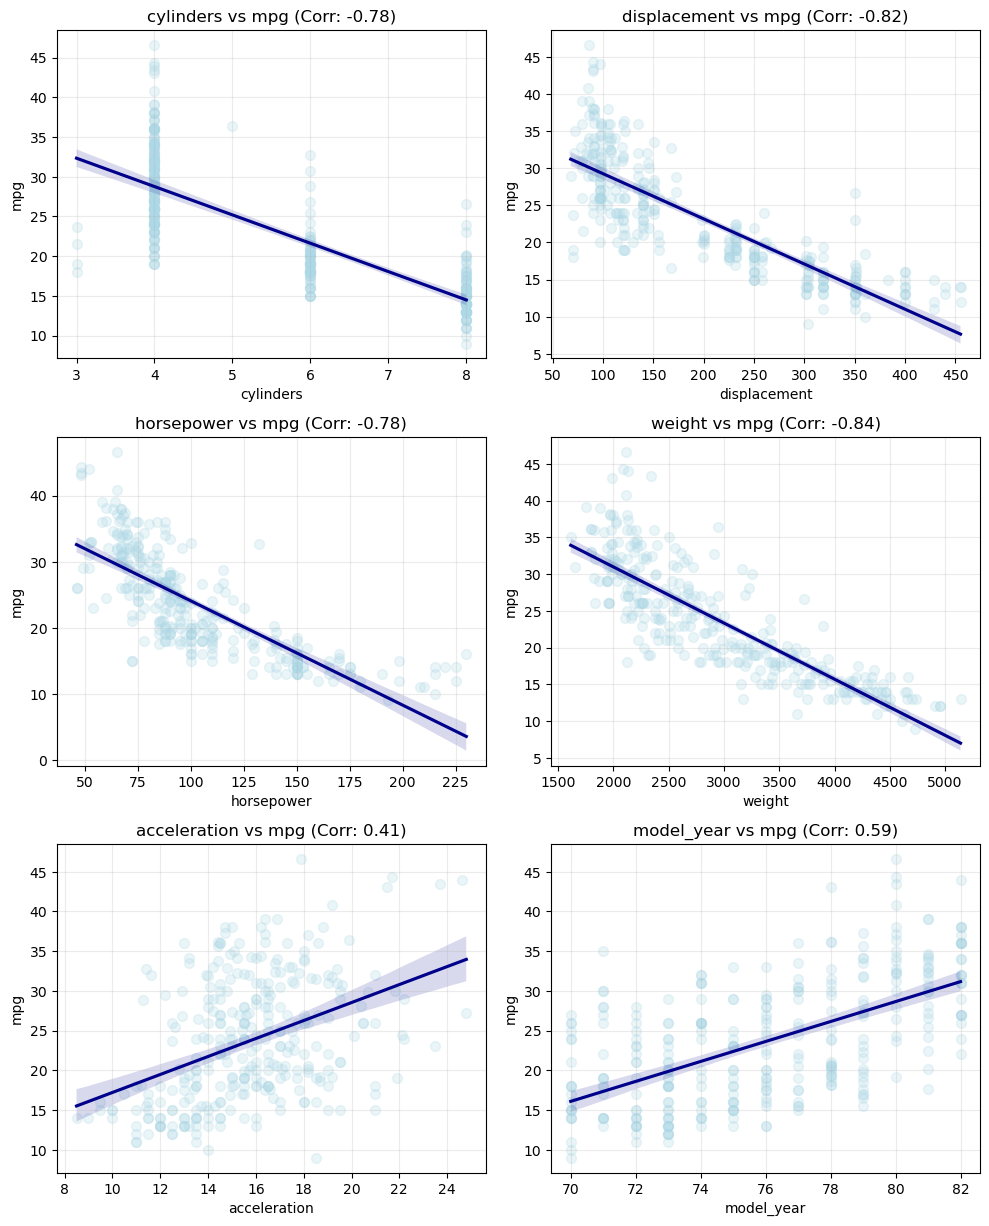

In [15]:
correlations = df_train.corr()["mpg"].drop("mpg")
variables = correlations.index

plt.figure(figsize=(10, 16))

for i, var in enumerate(variables):
    plt.subplot(4, 2, i + 1)
    sns.regplot(
        x=df_train[var], 
        y=df_train["mpg"],
        ci=95,
        scatter_kws={"color": "lightblue", "s": 50, "alpha": 0.25},
        line_kws={"color": "darkblue"}
    )
    plt.grid(True, alpha = 0.25)
    plt.xlabel(var)
    plt.ylabel("mpg")
    plt.title(f"{var} vs mpg (Corr: {correlations[var]:.2f})")

plt.tight_layout()
plt.show()

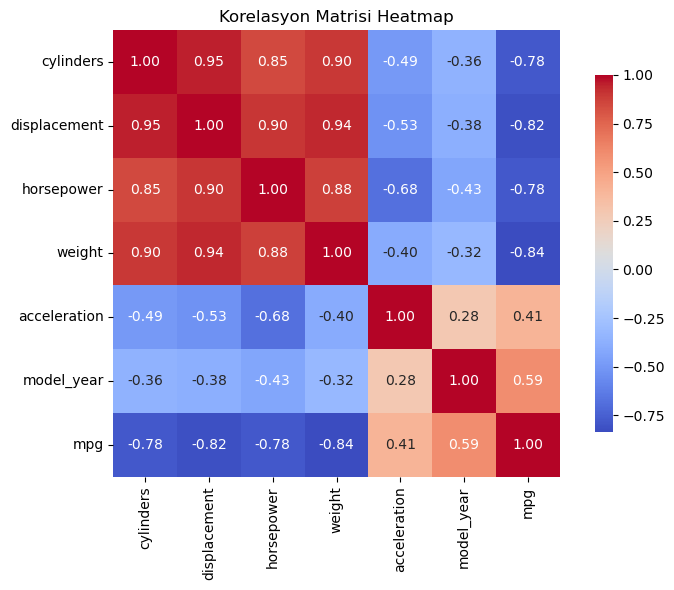

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Korelasyon Matrisi Heatmap")
plt.tight_layout()
plt.show()

In [17]:
alpha = 0.05

In [18]:
from scipy.stats import pearsonr

for i in range(X_train.shape[1]):
    correlation, p_value = pearsonr(X_train.iloc[:, i], y_train)
    print(f"{X_train.columns[i]}:")
    print(f"  Pearson Korelasyon Katsayısı: {correlation:.2f}")
    print(f"  P-değeri: {p_value:.4f}")
    if p_value < alpha:
        print("  Bu değişken ile bağımlı değişken arasındaki korelasyon istatistiksel olarak anlamlıdır.\n")
    else:
        print("  Bu değişken ile bağımlı değişken arasındaki korelasyon istatistiksel olarak anlamlı değildir.\n")

cylinders:
  Pearson Korelasyon Katsayısı: -0.78
  P-değeri: 0.0000
  Bu değişken ile bağımlı değişken arasındaki korelasyon istatistiksel olarak anlamlıdır.

displacement:
  Pearson Korelasyon Katsayısı: -0.82
  P-değeri: 0.0000
  Bu değişken ile bağımlı değişken arasındaki korelasyon istatistiksel olarak anlamlıdır.

horsepower:
  Pearson Korelasyon Katsayısı: -0.78
  P-değeri: 0.0000
  Bu değişken ile bağımlı değişken arasındaki korelasyon istatistiksel olarak anlamlıdır.

weight:
  Pearson Korelasyon Katsayısı: -0.84
  P-değeri: 0.0000
  Bu değişken ile bağımlı değişken arasındaki korelasyon istatistiksel olarak anlamlıdır.

acceleration:
  Pearson Korelasyon Katsayısı: 0.41
  P-değeri: 0.0000
  Bu değişken ile bağımlı değişken arasındaki korelasyon istatistiksel olarak anlamlıdır.

model_year:
  Pearson Korelasyon Katsayısı: 0.59
  P-değeri: 0.0000
  Bu değişken ile bağımlı değişken arasındaki korelasyon istatistiksel olarak anlamlıdır.



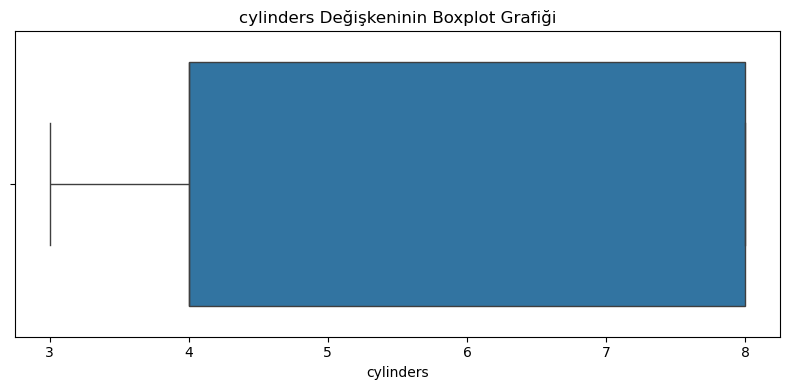

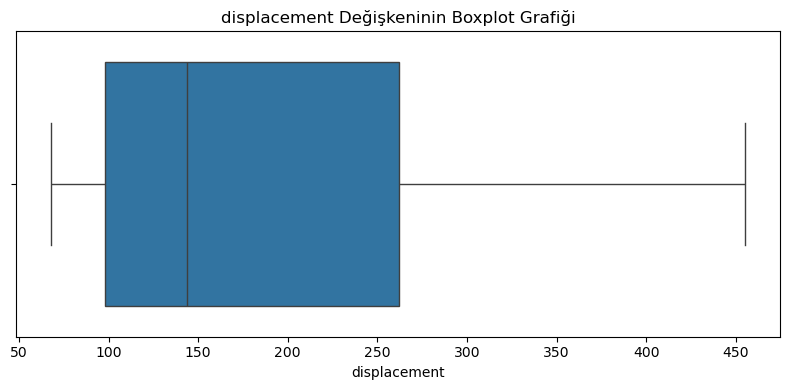

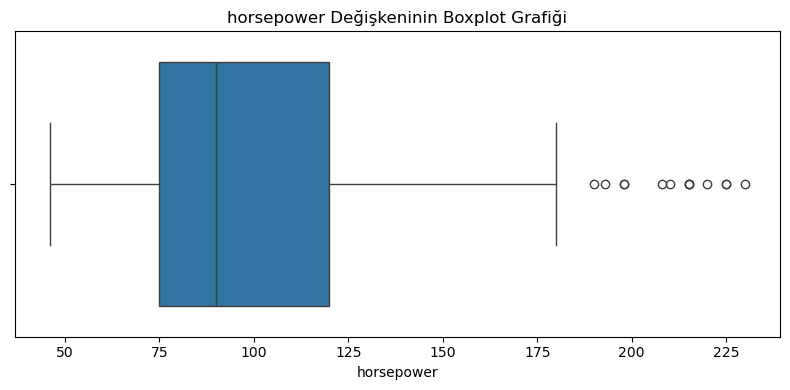

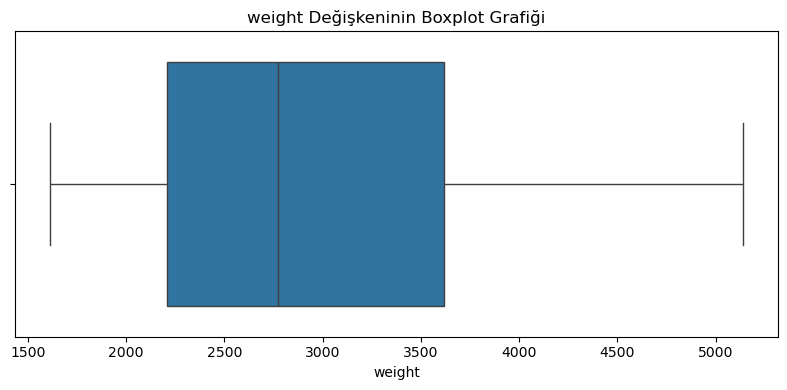

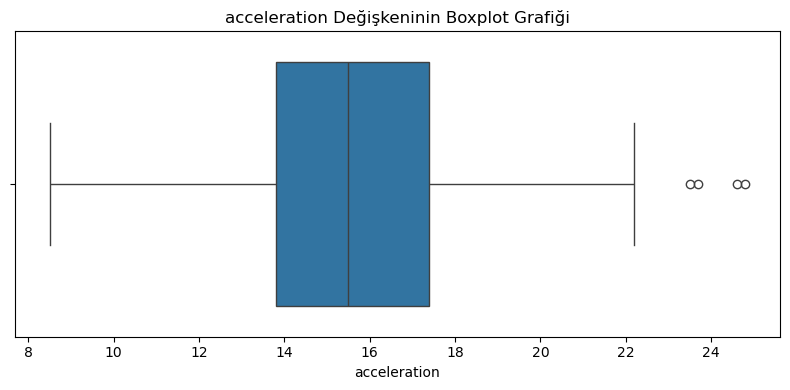

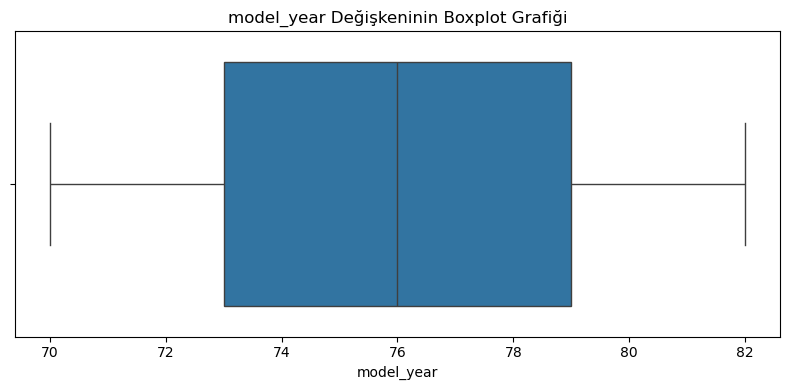

In [19]:
def plot_distributions(df, plot_type='hist', grid=False):
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df, columns=["Değişken"])
    elif isinstance(df, pd.Series):
        df = df.to_frame()

    for col in df.columns:
        plt.figure(figsize=(8, 4))

        if plot_type == 'hist':
            bins = math.ceil(np.log2(len(df[col])) + 1)
            sns.histplot(df[col], bins=bins, edgecolor='k')
            plt.xlabel("Değerler")
            plt.ylabel("Frekans")
            plt.title(f"{col} Değişkeninin Histogram Grafiği")

        elif plot_type == 'box':
            sns.boxplot(x=df[col])
            plt.title(f"{col} Değişkeninin Boxplot Grafiği")

        else:
            print(f"Bilinmeyen plot_type: {plot_type}. 'hist' veya 'box' kullanın.")
            return

        plt.grid(grid)
        plt.tight_layout()
        plt.show()
        print("\n")

plot_distributions(X_train, plot_type='box')

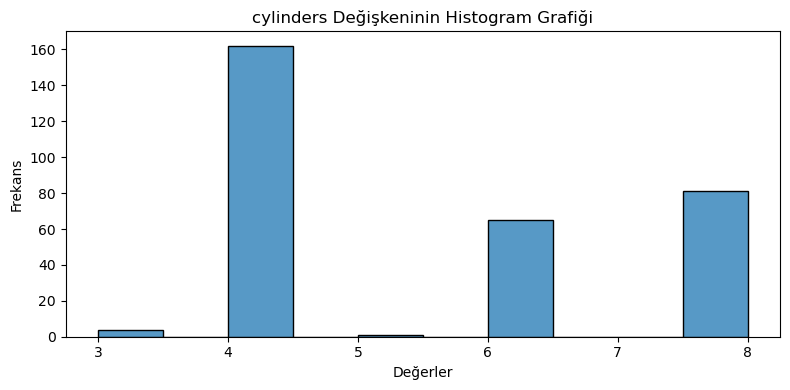

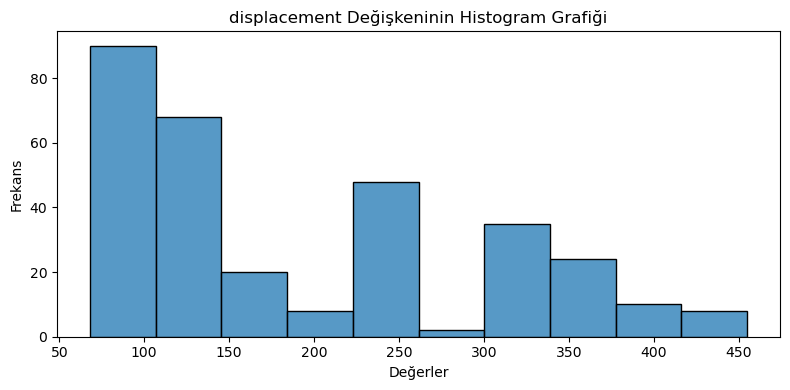

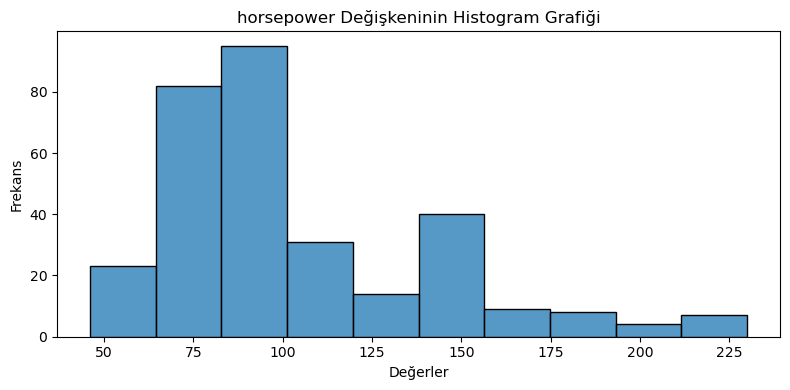

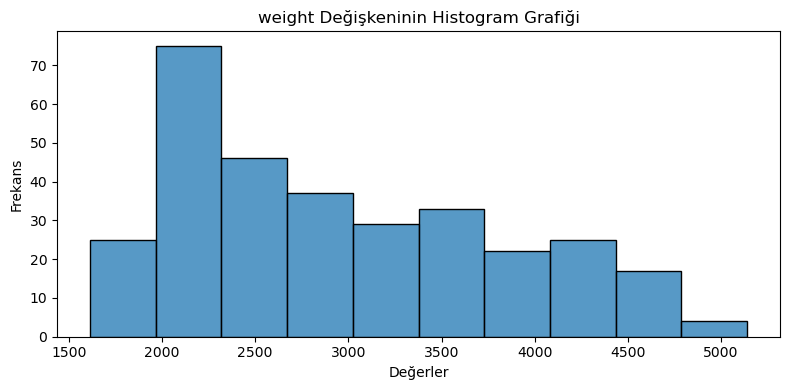

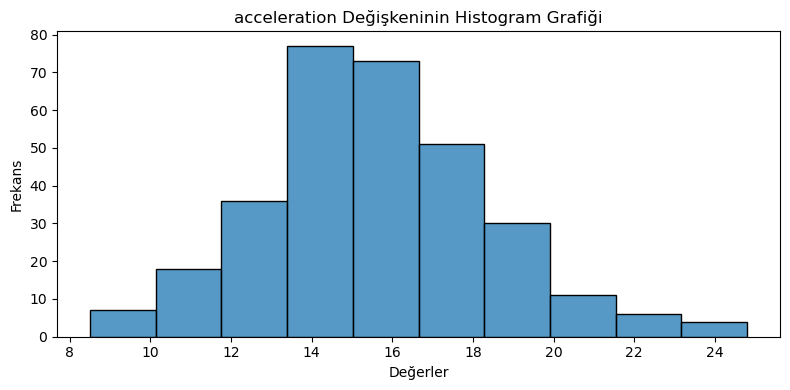

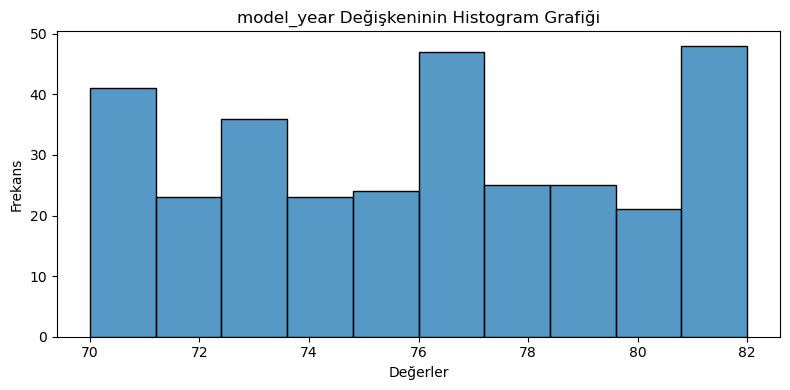

In [20]:
plot_distributions(X_train, plot_type='hist')

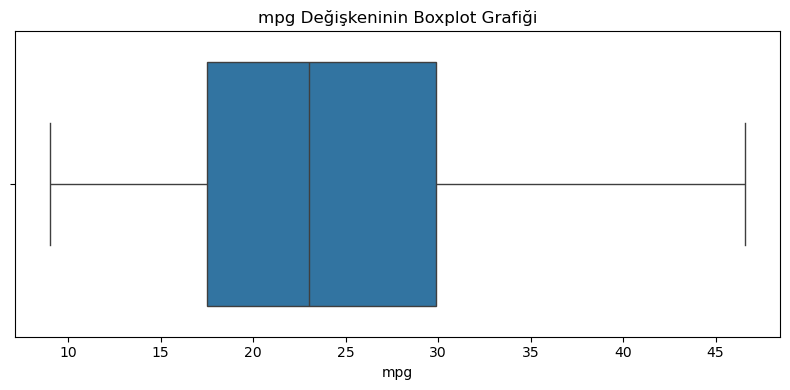

In [21]:
plot_distributions(y_train, plot_type='box')

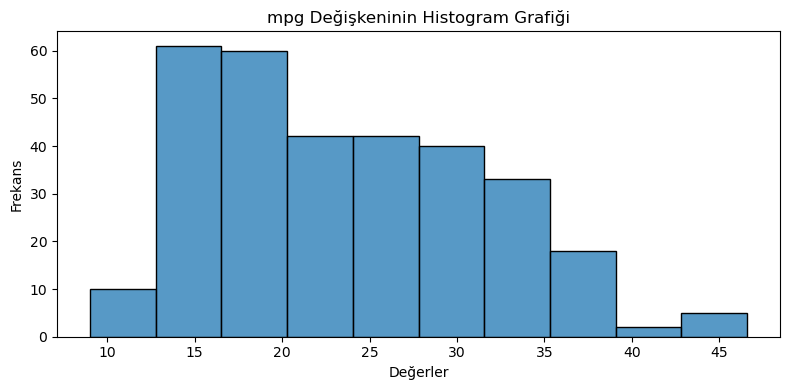

In [22]:
plot_distributions(y_train, plot_type='hist')

In [23]:
model = ElasticNet(max_iter=50000, tol=1e-4, fit_intercept=True)
model.fit(X_train, y_train)

ElasticNet(max_iter=50000)

In [24]:
y_train_pred = model.predict(X_train)
residuals = y_train - y_train_pred

In [25]:
train_r2 = r2_score(y_train, y_train_pred)
print(train_r2)

0.8165927137292665


In [26]:
train_mae = mean_absolute_error(y_train, y_train_pred) 
print(train_mae)

2.5186166827626875


In [27]:
train_dw = durbin_watson(residuals)
train_dw

np.float64(1.9852716077977381)

In [28]:
def perform_and_print_assumption_tests(residuals, exog):
    shapiro_stat, shapiro_p = shapiro(residuals)
    print(f"\nShapiro-Wilk Testi: W İstatistiği = {shapiro_stat:.2f}, p değeri = {shapiro_p:.5f}")
    if shapiro_p < alpha:
        print("İstatistiksel olarak, artıkların normal dağıldığı anlamlı bir şekilde söylenemez.")
    else:
        print("İstatistiksel olarak, artıkların normal dağıldığı anlamlı bir şekilde söylenebilir.")

    bp_stat, bp_p, _, _ = het_breuschpagan(residuals, sm.add_constant(exog))
    print(f"\nBreusch-Pagan Testi: p değeri = {bp_p:.5f}")
    if bp_p < alpha:
        print("İstatistiksel olarak, artıkların sabit varyansa sahip olduğu anlamlı bir şekilde söylenemez.")
    else:
        print("İstatistiksel olarak, artıkların sabit varyansa sahip olduğu anlamlı bir şekilde söylenebilir.")

perform_and_print_assumption_tests(residuals, X_train)


Shapiro-Wilk Testi: W İstatistiği = 0.97, p değeri = 0.00000
İstatistiksel olarak, artıkların normal dağıldığı anlamlı bir şekilde söylenemez.

Breusch-Pagan Testi: p değeri = 0.00009
İstatistiksel olarak, artıkların sabit varyansa sahip olduğu anlamlı bir şekilde söylenemez.


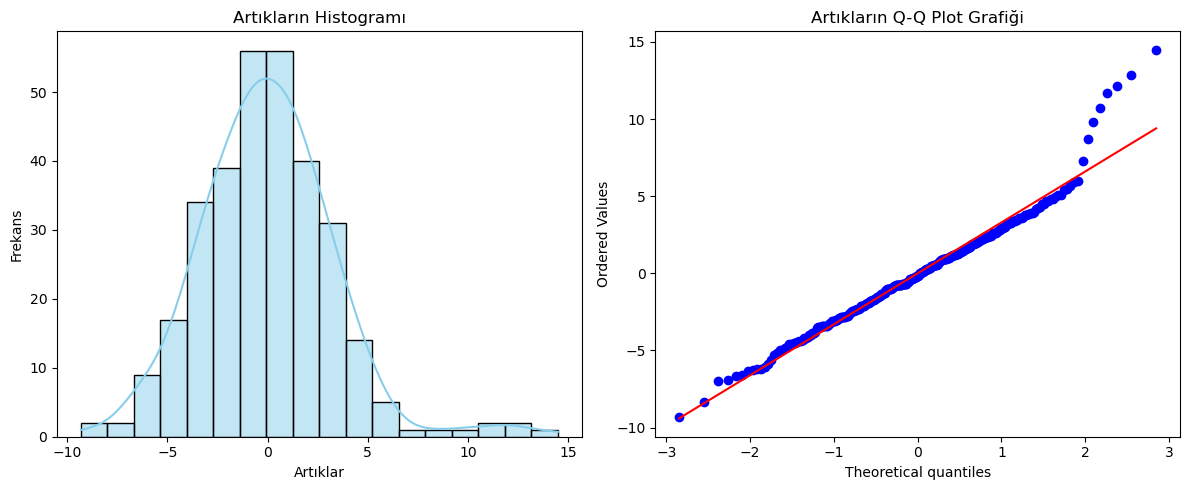

In [29]:
def plot_residuals(residuals):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True, bins=math.ceil(math.sqrt(len(residuals))), color='skyblue')
    plt.title("Artıkların Histogramı")
    plt.xlabel("Artıklar")
    plt.ylabel("Frekans")

    plt.subplot(1, 2, 2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Artıkların Q-Q Plot Grafiği")

    plt.tight_layout()
    plt.show()

plot_residuals(residuals)

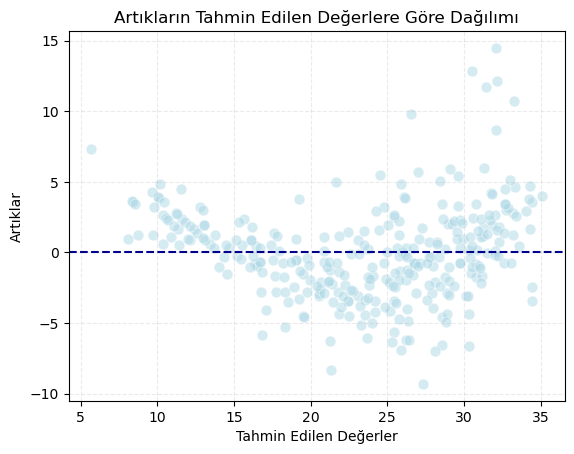

In [30]:
def plot_residuals_vs_fitted(fitted_values, residuals):
    sns.scatterplot(
        x=fitted_values, 
        y=residuals, 
        alpha=0.50, 
        color='lightblue', 
        s=60
    )
    
    plt.axhline(y=0, color='darkblue', linestyle='--')
    
    plt.title("Artıkların Tahmin Edilen Değerlere Göre Dağılımı", fontsize=12)
    plt.xlabel("Tahmin Edilen Değerler", fontsize=10)
    plt.ylabel("Artıklar", fontsize=10)
    
    plt.grid(True, linestyle='--', alpha=0.25)
    
    plt.show()

plot_residuals_vs_fitted(y_train_pred, residuals)

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Bağımsız değişkenler standardize edildi.")

Bağımsız değişkenler standardize edildi.


In [32]:
n_list = [5, 10, 25, 50, 75, 100, 200, 250]
c_list = [0.01, 0.05, 0.075, 0.10, 0.15]

lof_model = ElasticNet(
    max_iter=50000, tol=1e-4, fit_intercept=True
)

records = []
for n in n_list:
    for c in c_list:
        lof = LocalOutlierFactor(n_neighbors=n, contamination=c)
        y_lof = lof.fit_predict(X_train_scaled)
        
        mask = (y_lof == 1)
        X_in, y_in = X_train_scaled[mask], y_train[mask]

        lof_model.fit(X_in, y_in) 
        
        y_pred = lof_model.predict(X_in) 
        
        resid_in = y_in - y_pred
        
        stat_sw, p_sw = shapiro(resid_in)
        
        exog_in = sm.add_constant(X_in) 
        _, p_bp, _, _ = het_breuschpagan(resid_in, exog_in)
        
        r2 = r2_score(y_in, y_pred)

        records.append({
            'n_neighbors':   n,
            'Contamination': c,
            'n_inliers':     X_in.shape[0],
            'Sharipo Wilk p':     p_sw,
            'Breusch–Pagan p': p_bp,         
            'p_sum':         p_sw + p_bp,
            'R2':            r2             
        })

results_df = pd.DataFrame(records)

def format_df(df_subset):
    df_fmt = df_subset.copy()
    df_fmt['n_neighbors']    = df_fmt['n_neighbors'].astype(str)
    df_fmt['Contamination']  = df_fmt['Contamination'].apply(lambda x: f"{x:.3f}")
    df_fmt['n_inliers']      = df_fmt['n_inliers'].astype(str)
    df_fmt['Sharipo Wilk p'] = df_fmt['Sharipo Wilk p'].apply(lambda x: f"{x:.4f}")
    df_fmt['Breusch–Pagan p']= df_fmt['Breusch–Pagan p'].apply(lambda x: f"{x:.5f}") 
    df_fmt['p_sum']          = df_fmt['p_sum'].apply(lambda x: f"{x:.5f}")
    df_fmt['R2']             = df_fmt['R2'].apply(lambda x: f"{x:.3f}")
    return df_fmt.reset_index(drop=True)


print("\nA) Tüm kombinasyonlar:")
full_fmt = format_df(results_df)
print(tabulate(full_fmt, headers="keys", tablefmt="github", showindex=range(1, len(full_fmt) + 1)))

candidates = results_df[(results_df['Sharipo Wilk p'] >= alpha) & (results_df['Breusch–Pagan p'] >= alpha)]

if not candidates.empty:
    cand_fmt = format_df(candidates)
    print(f"\nC) Her iki varsayımı da sağlayan kombinasyonlar:")
    print(tabulate(cand_fmt, headers="keys", tablefmt="github", showindex=range(1, len(cand_fmt)+1)))
else:
    print(f"\nC) Her iki varsayımı da sağlayan bir kombinasyon bulunamadı.")
    top5_psum = results_df.nlargest(5, 'p_sum')
    psum_fmt = format_df(top5_psum)
    print("\nB) p_sum'a (p değerleri toplamına) göre en yüksek ilk 5 kombinasyon:")
    print(tabulate(psum_fmt, headers="keys", tablefmt="github", showindex=range(1, len(psum_fmt)+1)))

print("\nD) R2’ye göre en yüksek ilk 5 kombinasyon:")
top5_r2 = results_df.nlargest(5, 'R2')
r2_fmt  = format_df(top5_r2)
print(tabulate(r2_fmt, headers="keys", tablefmt="github", showindex=range(1, len(r2_fmt)+1)))

print("\nE) Sharipo Wilk p'ye göre en yüksek ilk 5 kombinasyon:")
top5_shapiro = results_df.nlargest(5, 'Sharipo Wilk p')
shapiro_fmt = format_df(top5_shapiro)
print(tabulate(shapiro_fmt, headers="keys", tablefmt="github", showindex=range(1, len(shapiro_fmt)+1)))

print("\nF) Breusch–Pagan p'ye göre en yüksek ilk 5 kombinasyon:")
top5_bp = results_df.nlargest(5, 'Breusch–Pagan p')
bp_fmt = format_df(top5_bp)
print(tabulate(bp_fmt, headers="keys", tablefmt="github", showindex=range(1, len(bp_fmt)+1)))


A) Tüm kombinasyonlar:
|    |   n_neighbors |   Contamination |   n_inliers |   Sharipo Wilk p |   Breusch–Pagan p |   p_sum |    R2 |
|----|---------------|-----------------|-------------|------------------|-------------------|---------|-------|
|  1 |             5 |           0.01  |         309 |                0 |             0     |   0     | 0.751 |
|  2 |             5 |           0.05  |         297 |                0 |             0     |   0     | 0.762 |
|  3 |             5 |           0.075 |         289 |                0 |             0     |   0     | 0.769 |
|  4 |             5 |           0.1   |         281 |                0 |             0     |   0     | 0.777 |
|  5 |             5 |           0.15  |         266 |                0 |             1e-05 |   1e-05 | 0.788 |
|  6 |            10 |           0.01  |         309 |                0 |             0     |   0     | 0.753 |
|  7 |            10 |           0.05  |         297 |                0 |       

In [33]:
best_n = 75
best_contamination = 0.05
lof = LocalOutlierFactor(n_neighbors=best_n, contamination=best_contamination)

In [34]:
lof.fit(X_train_scaled)

LocalOutlierFactor(contamination=0.05, n_neighbors=75)

In [35]:
X_train_scores = lof.negative_outlier_factor_
sorted_scores = np.sort(X_train_scores)

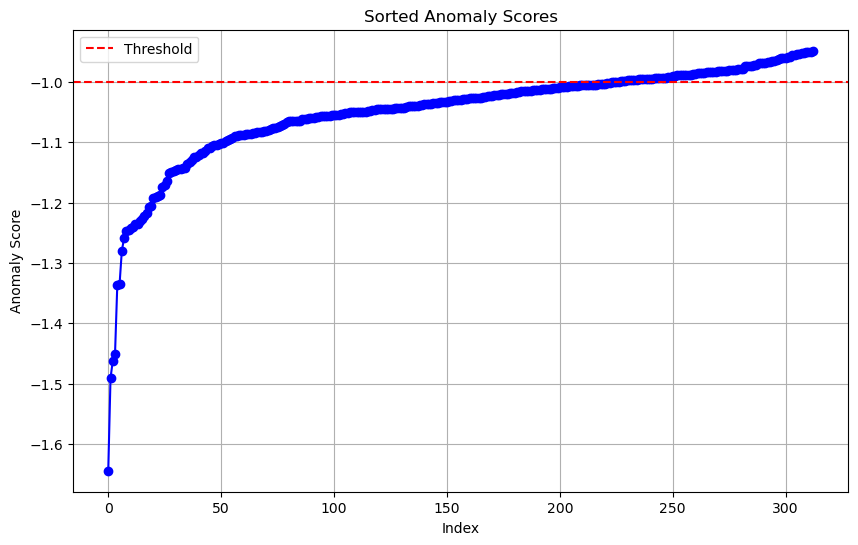

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_scores, marker='o', linestyle='-', color='b')
plt.title('Sorted Anomaly Scores')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.axhline(y=-1.0, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.grid()
plt.show()

In [37]:
outlier_mask = lof.fit_predict(X_train_scaled) == 1

X_train_scaled_no_outliers = X_train_scaled.loc[outlier_mask]
y_train_no_outliers = y_train.loc[outlier_mask]

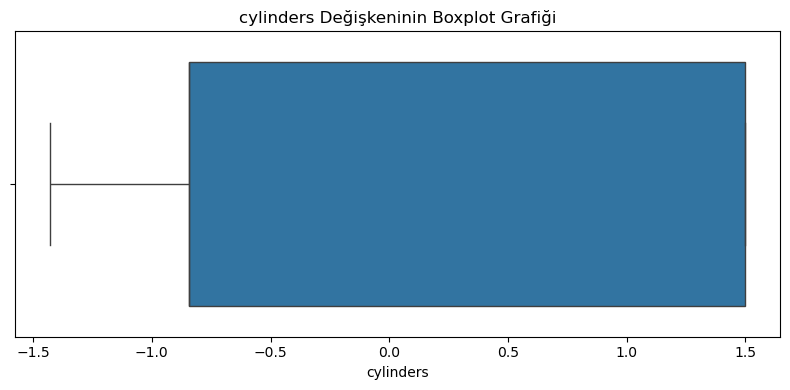

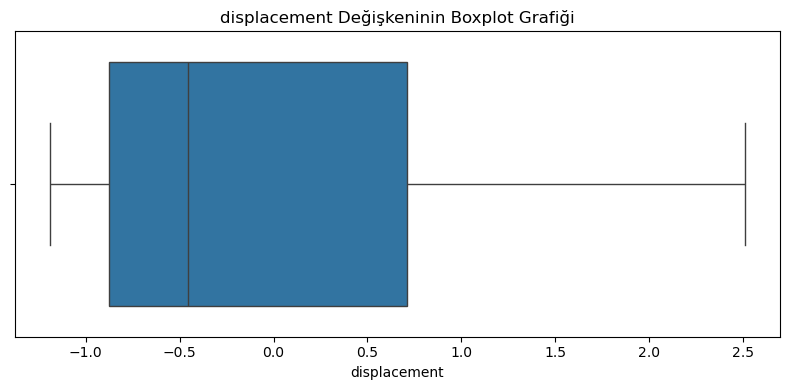

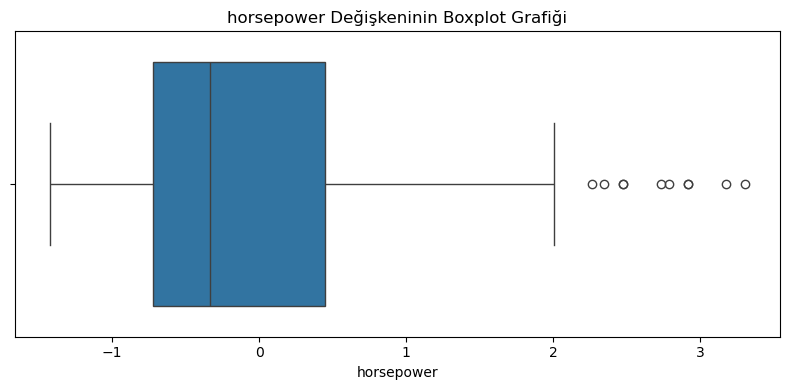

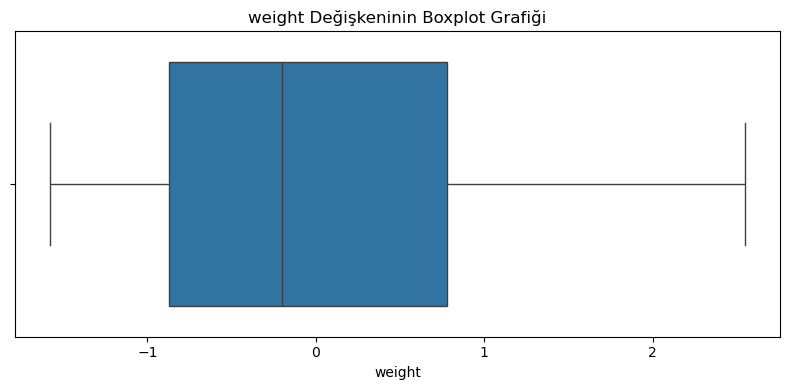

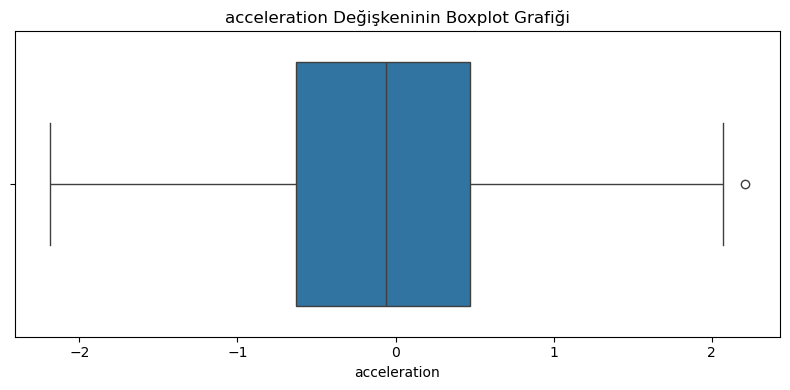

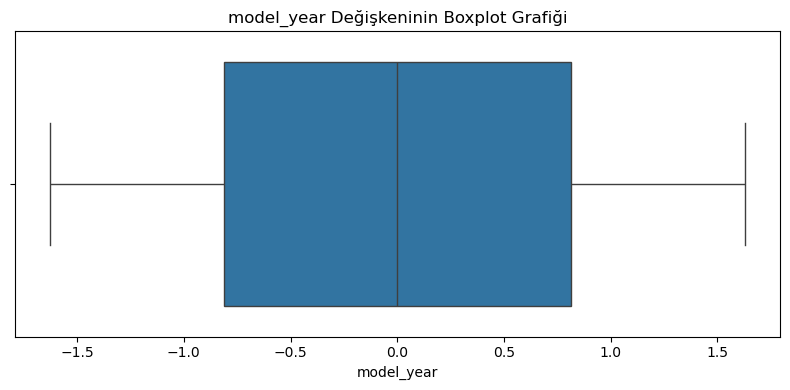

In [38]:
plot_distributions(X_train_scaled_no_outliers, plot_type='box')

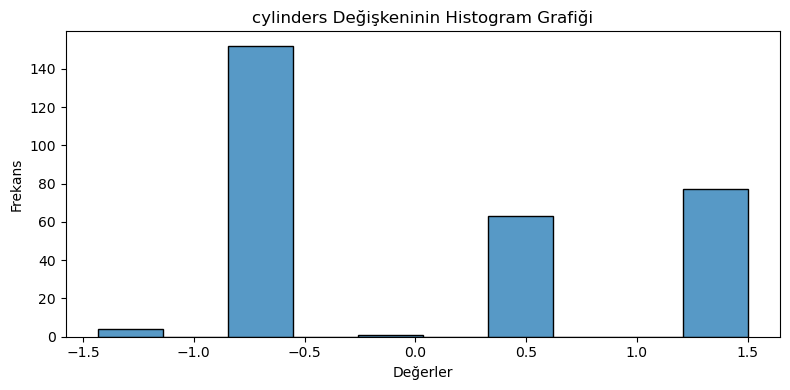

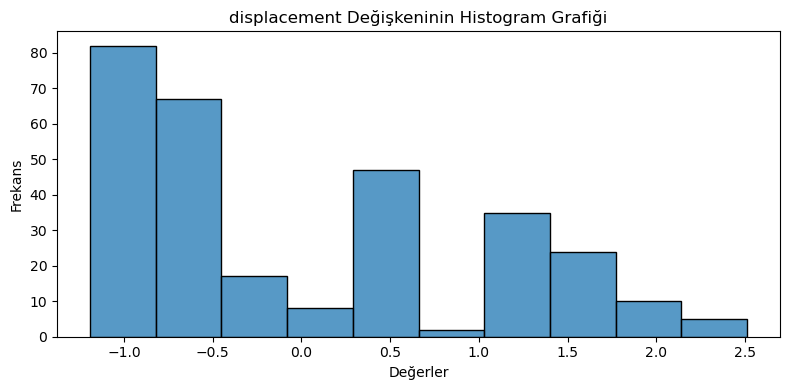

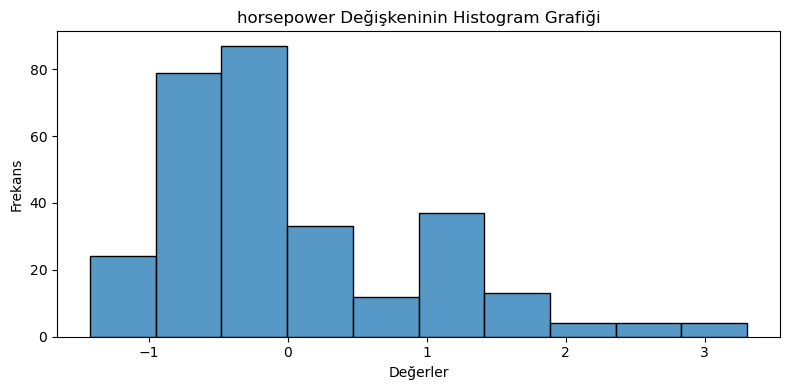

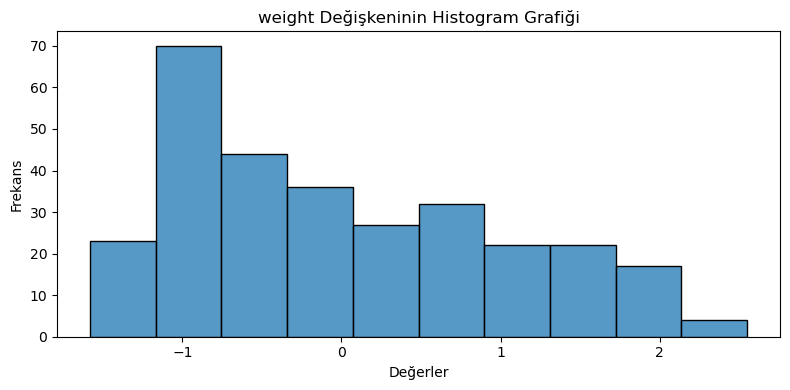

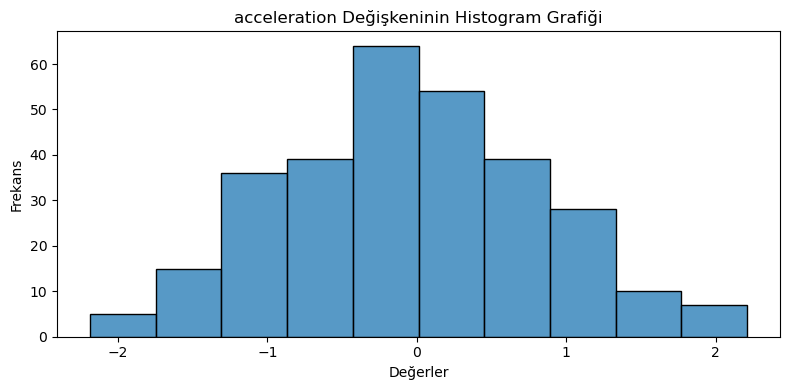

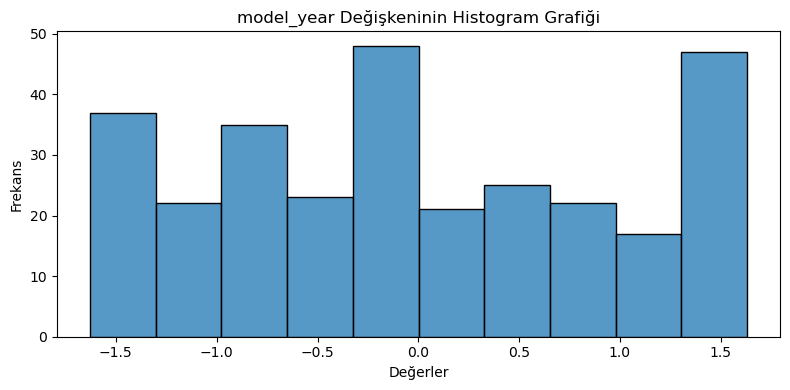

In [39]:
plot_distributions(X_train_scaled_no_outliers, plot_type='hist')

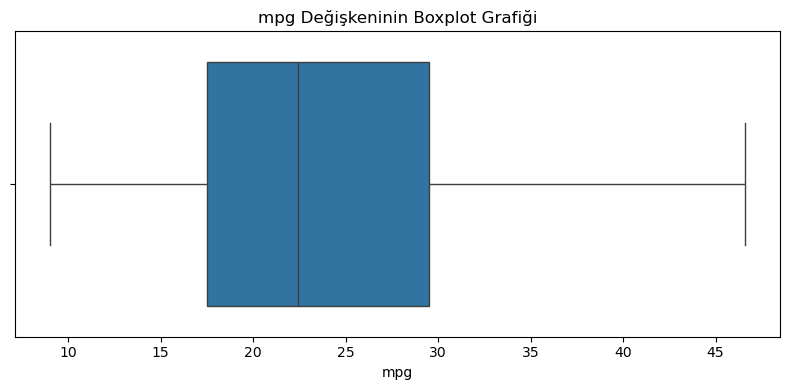

In [40]:
plot_distributions(y_train_no_outliers, plot_type='box')

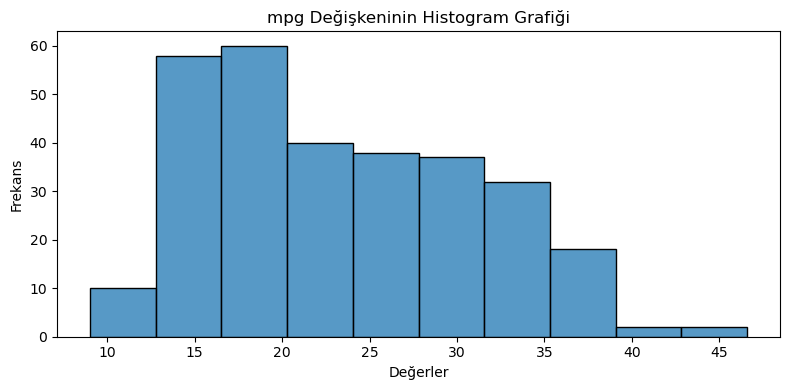

In [41]:
plot_distributions(y_train_no_outliers, plot_type='hist')

In [42]:
model_no_outliers = ElasticNet(
    max_iter=50000, tol=1e-4, fit_intercept=True
)
model_no_outliers.fit(X_train_scaled_no_outliers, y_train_no_outliers)

ElasticNet(max_iter=50000)

In [43]:
y_pred_no_outliers = model_no_outliers.predict(X_train_scaled_no_outliers)
resid_no_outliers = y_train_no_outliers - y_pred_no_outliers

In [44]:
train_r2_no_outliers = r2_score(y_train_no_outliers, y_pred_no_outliers)
print(train_r2_no_outliers)

0.7698011003561599


In [45]:
train_mae_no_outliers = mean_absolute_error(y_train_no_outliers, y_pred_no_outliers) 
print(train_mae_no_outliers)

2.830503215137003


In [46]:
train_dw_no_outliers = durbin_watson(resid_no_outliers)
train_dw_no_outliers

np.float64(2.090570954640339)

In [47]:
perform_and_print_assumption_tests(resid_no_outliers, X_train_scaled_no_outliers)


Shapiro-Wilk Testi: W İstatistiği = 0.97, p değeri = 0.00000
İstatistiksel olarak, artıkların normal dağıldığı anlamlı bir şekilde söylenemez.

Breusch-Pagan Testi: p değeri = 0.00000
İstatistiksel olarak, artıkların sabit varyansa sahip olduğu anlamlı bir şekilde söylenemez.


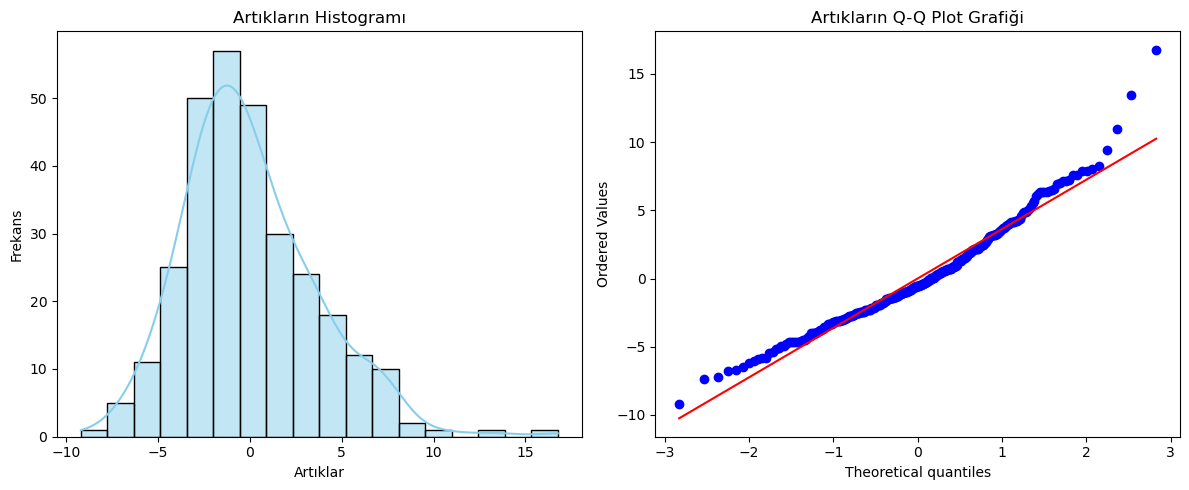

In [48]:
plot_residuals(resid_no_outliers)

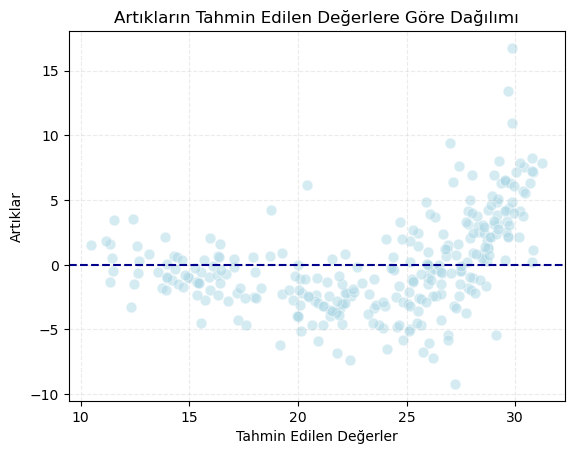

In [49]:
plot_residuals_vs_fitted(y_pred_no_outliers, resid_no_outliers)

In [50]:
class TransformationError(Exception):
    pass

def apply_transformation_safe(data, transform_type, return_lambda=False):
    arr = np.asarray(data, dtype=float)
    
    if transform_type == "Square":
        return arr ** 2
    if transform_type == "Original":
        return arr.copy()

    min_val = arr.min()
    
    if transform_type in ["Log", "Sqrt", "Box-Cox"]:
        if min_val <= 0:
            shift = -min_val + 1e-9
            arr = arr + shift
    
    if transform_type == "Reciprocal":
        arr[np.isclose(arr, 0)] = 1e-9

    if transform_type == "Log":
        return np.log(arr)
    if transform_type == "Sqrt":
        return np.sqrt(arr)
    if transform_type == "Box-Cox":
        result, lam = stats.boxcox(arr)
        if return_lambda:
            return result, lam 
        else:
            return result
    if transform_type == "Reciprocal":
        return 1.0 / arr
    
    raise ValueError(f"Bilinmeyen dönüşüm tipi: {transform_type}")

transformation_types = ["Original", "Log", "Sqrt", "Reciprocal", "Box-Cox", "Square"]
alphas_cv = [0.0001, 0.001, 0.01, 0.1, 1.0] 
l1_ratios = [0.1, 0.5, 0.9]

features = X_train_scaled_no_outliers.columns.tolist()
y_raw = np.asarray(y_train_no_outliers)
X_raw = X_train_scaled_no_outliers.copy()

def process_combination(y_tr, combo, features, y_data, X_data, alpha_significance):
    try:
        y_transformed = apply_transformation_safe(y_data, y_tr)
        
        X_transformed_cols = []
        for i, x_tr in enumerate(combo):
            feature_name = features[i]
            col_data = X_data[feature_name].values
            transformed_col = apply_transformation_safe(col_data, x_tr)
            X_transformed_cols.append(transformed_col)
        
        X_std = np.column_stack(X_transformed_cols)
        
        enet_cv = ElasticNetCV(alphas=alphas_cv, l1_ratio=l1_ratios,
                               max_iter=50000, tol=1e-4, fit_intercept=True, cv=3, random_state = 123, n_jobs=1)
        enet_cv.fit(X_std, y_transformed)

        pred = enet_cv.predict(X_std)
        res = y_transformed - pred

        if len(res) < 3:
            return "HATA: Artık sayısı testler için yetersiz."
        
        _, norm_p = stats.shapiro(res)
        _, bp_p, _, _ = het_breuschpagan(res, sm.add_constant(X_std))

        return {
            "Y Transformation": y_tr,
            "X Transformation": ", ".join(combo),
            "R2": r2_score(y_transformed, pred),
            "Shapiro p": norm_p,
            "BP p": bp_p,
            "Alpha": enet_cv.alpha_,
            "L1 Ratio": enet_cv.l1_ratio_
        }
    
    except Exception as e:
        return f"İŞLEM HATASI: {y_tr}, {combo} -> {str(e)}\n{traceback.format_exc()}"

all_x_combos = list(itertools.product(transformation_types, repeat=len(features)))
tasks = [(y_tr, combo) for y_tr in transformation_types for combo in all_x_combos]

results_list = Parallel(n_jobs=-1, verbose=0, batch_size='auto', pre_dispatch='2*n_jobs', backend='loky')(
    delayed(process_combination)(y_tr, combo, features, y_raw, X_raw, alpha) for y_tr, combo in tasks
)

errors = [r for r in results_list if isinstance(r, str)]
results_df = pd.DataFrame([r for r in results_list if isinstance(r, dict)])

print(f"İşlem tamamlandı. Toplam {len(tasks)} görev işlendi.")
print(f"Başarılı sonuç sayısı: {len(results_df)}")

if errors:
    print("\n--- Hata Özeti ---")
    error_summary = Counter([e.split('->')[0].strip() if '->' in e else 'Genel Hata' for e in errors])
    for msg, count in error_summary.most_common(5):
        print(f"- {count} kez: {msg}")
print("-"*60)

if results_df.empty:
    print("Hiçbir dönüşüm kombinasyonu başarıyla tamamlanamadı.")
else:
    results_df['Normality'] = results_df['Shapiro p'] > alpha
    results_df['Homoscedasticity'] = results_df['BP p'] > alpha

    def format_for_display(df, cols_to_show):
        display_df = df.copy()
        for col in ["R2", "Shapiro p", "BP p", "Alpha", "L1 Ratio"]:
            if col in display_df.columns:
                display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
        return display_df[cols_to_show]

    both_assumptions_met = results_df[
        results_df['Normality'] & results_df['Homoscedasticity']
    ].sort_values(by="R2", ascending=False).head(5)

    if not both_assumptions_met.empty:
        print("\nHem Normallik hem de Sabit Varyanslılık Varsayımını Sağlayan En İyi 5 Kombinasyon (R2'ye göre sıralanmış):")
        cols = ['Y Transformation', 'X Transformation', 'R2', 'Shapiro p', 'BP p', 'Alpha', 'L1 Ratio']
        display_df = format_for_display(both_assumptions_met, cols)
        print(tabulate(display_df, headers='keys', tablefmt="pretty", showindex=False))
        
        best = both_assumptions_met.iloc[0]
        print(f"\n En İyi Kombinasyon ve Sonuçları:")
        print(f"   - Y Dönüşümü: {best['Y Transformation']}")
        print(f"   - X Dönüşümleri: {best['X Transformation']}")
        print(f"   - R2: {best['R2']:.4f}")
        print(f"   - Shapiro p-değeri: {best['Shapiro p']:.4f} (> {alpha})")
        print(f"   - Breusch–Pagan p-değeri: {best['BP p']:.4f} (> {alpha})")
        print(f"   - Alpha: {best['Alpha']:.4f}")
        print(f"   - L1 Ratio: {best['L1 Ratio']:.4f}")

    else:
        print("\nHiçbir kombinasyon her iki varsayımı (Normallik ve Sabit Varyanslılık) aynı anda sağlayamadı.")
        print("Aşağıda her bir varsayımı ayrı ayrı sağlayan ve R2'si en yüksek olan seçenekler gösterilmektedir:\n")
        
        normality_met = results_df[results_df['Normality']].sort_values(by="R2", ascending=False).head(5)
        if not normality_met.empty:
            print("Normallik Varsayımını Sağlayan En İyi 5 Kombinasyon (R2'ye göre sıralanmış):")
            cols = ['Y Transformation', 'X Transformation', 'R2', 'Shapiro p', 'BP p', 'Alpha', 'L1 Ratio']
            display_df = format_for_display(normality_met, cols)
            print(tabulate(display_df, headers='keys', tablefmt="pretty", showindex=False))
        else:
            print("Normallik varsayımını sağlayan hiçbir kombinasyon bulunamadı.")

        print("\n" + "-"*80 + "\n")

        homoscedasticity_met = results_df[results_df['Homoscedasticity']].sort_values(by="R2", ascending=False).head(5)
        if not homoscedasticity_met.empty:
            print("Sabit Varyanslılık Varsayımını Sağlayan En İyi 5 Kombinasyon (R2'ye göre sıralanmış):")
            cols = ['Y Transformation', 'X Transformation', 'R2', 'Shapiro p', 'BP p', 'Alpha', 'L1 Ratio']
            display_df = format_for_display(homoscedasticity_met, cols)
            print(tabulate(display_df, headers='keys', tablefmt="pretty", showindex=False))
        else:
            print("Sabit varyanslılık varsayımını sağlayan hiçbir kombinasyon bulunamadı.")
    
    print("\n" + "-"*80 + "\n")
    print("Varsayımlardan Bağımsız Olarak En Yüksek R2 Değerine Sahip 5 Kombinasyon:")
    cols = ['Y Transformation', 'X Transformation', 'R2', 'Shapiro p', 'BP p', 'Alpha', 'L1 Ratio']
    top_r2_combos = results_df.sort_values(by="R2", ascending=False).head(5)
    display_df = format_for_display(top_r2_combos, cols)
    print(tabulate(display_df, headers='keys', tablefmt="pretty", showindex=False))

İşlem tamamlandı. Toplam 279936 görev işlendi.
Başarılı sonuç sayısı: 279936
------------------------------------------------------------

Hem Normallik hem de Sabit Varyanslılık Varsayımını Sağlayan En İyi 5 Kombinasyon (R2'ye göre sıralanmış):
+------------------+---------------------------------------------------+--------+-----------+--------+--------+----------+
| Y Transformation |                 X Transformation                  |   R2   | Shapiro p |  BP p  | Alpha  | L1 Ratio |
+------------------+---------------------------------------------------+--------+-----------+--------+--------+----------+
|     Box-Cox      |      Log, Sqrt, Log, Sqrt, Square, Original       | 0.9034 |  0.0530   | 0.0667 | 0.0100 |  0.1000  |
|     Box-Cox      | Reciprocal, Reciprocal, Sqrt, Sqrt, Log, Original | 0.9019 |  0.0519   | 0.9806 | 0.0100 |  0.5000  |
|     Box-Cox      |   Reciprocal, Square, Sqrt, Sqrt, Log, Original   | 0.9017 |  0.0538   | 0.9796 | 0.0100 |  0.5000  |
|     Box-Cox   

In [51]:
best_y_transform = 'Box-Cox'
best_x_transforms = ["Log", "Sqrt", "Log", "Sqrt", "Square", "Original"]

best_alpha = 0.01
best_l1_ratio = 0.1

y_name = y_train.name
feature_names = X_train_scaled_no_outliers.columns.tolist()

transformation_params = {}

print("En İyi Dönüşüm Kombinasyonu:")

print("-" * 40)

print(f"'{y_name}' Sütunu Dönüşümü: {best_y_transform}")
for feature, transform in zip(feature_names, best_x_transforms):
    print(f"'{feature}' Sütunu Dönüşümü: {transform}")

print("-" * 80)

y_train_original = y_train_no_outliers.values
params_y = {'shift': 0, 'lambda': None}

min_val_y = y_train_original.min()
if best_y_transform in ["Log", "Sqrt", "Box-Cox"] and min_val_y <= 0:
    params_y['shift'] = -min_val_y + 1e-9

data_to_transform_y = y_train_original + params_y['shift']

if best_y_transform == "Box-Cox":
    y_train_transformed, lam_y = stats.boxcox(data_to_transform_y)
    params_y['lambda'] = lam_y
    print(f"-> 'mpg' için Box-Cox dönüşümü uygulandı. (shift={params_y['shift']:.4f}, lambda={lam_y:.4f})")
else:
    y_train_transformed = apply_transformation_safe(pd.Series(data_to_transform_y), best_y_transform)
    print(f"-> 'mpg' için '{best_y_transform}' dönüşümü uygulandı. (shift={params_y['shift']:.4f})")

transformation_params['y'] = params_y

X_train_transformed = pd.DataFrame(index=X_train_scaled_no_outliers.index)

for i, col_name in enumerate(feature_names):
    transform_type = best_x_transforms[i]
    original_data = X_train_scaled_no_outliers[col_name].values
    
    params_x = {'shift': 0, 'lambda': None}
    
    min_val = original_data.min()
    if transform_type in ["Log", "Sqrt", "Box-Cox"] and min_val <= 0:
        params_x['shift'] = -min_val + 1e-9
    
    data_to_transform = original_data + params_x['shift']
    
    if transform_type == "Box-Cox":
        transformed_data, lam = stats.boxcox(data_to_transform)
        params_x['lambda'] = lam
        X_train_transformed[col_name] = transformed_data
        print(f"-> '{col_name}' için Box-Cox dönüşümü uygulandı. (shift={params_x['shift']:.4f}, lambda={lam:.4f})")
    else:
        X_train_transformed[col_name] = apply_transformation_safe(pd.Series(data_to_transform), transform_type)
        print(f"-> '{col_name}' için '{transform_type}' dönüşümü uygulandı. (shift={params_x['shift']:.4f})")
        
    transformation_params[col_name] = params_x

print("\nEğitim verisinin dönüşümü tamamlandı.")

print("-" * 60)

print("\nKaydedilen Parametreler:")
import json
print(json.dumps(transformation_params, indent=2))

En İyi Dönüşüm Kombinasyonu:
----------------------------------------
'mpg' Sütunu Dönüşümü: Box-Cox
'cylinders' Sütunu Dönüşümü: Log
'displacement' Sütunu Dönüşümü: Sqrt
'horsepower' Sütunu Dönüşümü: Log
'weight' Sütunu Dönüşümü: Sqrt
'acceleration' Sütunu Dönüşümü: Square
'model_year' Sütunu Dönüşümü: Original
--------------------------------------------------------------------------------
-> 'mpg' için Box-Cox dönüşümü uygulandı. (shift=0.0000, lambda=0.2639)
-> 'cylinders' için 'Log' dönüşümü uygulandı. (shift=1.4306)
-> 'displacement' için 'Sqrt' dönüşümü uygulandı. (shift=1.1920)
-> 'horsepower' için 'Log' dönüşümü uygulandı. (shift=1.4249)
-> 'weight' için 'Sqrt' dönüşümü uygulandı. (shift=1.5804)
-> 'acceleration' için 'Square' dönüşümü uygulandı. (shift=0.0000)
-> 'model_year' için 'Original' dönüşümü uygulandı. (shift=0.0000)

Eğitim verisinin dönüşümü tamamlandı.
------------------------------------------------------------

Kaydedilen Parametreler:
{
  "y": {
    "shift": 0,

In [52]:
def calculate_vif(X_data):

    X_for_vif = X_data.copy()
    
    vif_data = pd.DataFrame()
    vif_data["Değişken"] = X_for_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i) 
                       for i in range(X_for_vif.shape[1])]
    
    return vif_data

print("--- ÇOK DOĞRUSAL BAĞLANTI ANALİZİ (VIF) ---")
print("\nDönüştürülmüş Veriler için VIF Değerleri:")
vif_results = calculate_vif(X_train_transformed)
print(vif_results.to_string(index=False))

print("\n--- VIF DEĞERLENDİRMESİ")
print("VIF Değerlendirme Kriterleri:")
print("- VIF < 5   : Çoklu doğrusal bağlantı yok.")
print("- 5 ≤ VIF < 10 : Orta düzeyde çoklu doğrusal bağlantı var.")
print("- VIF ≥ 10  : Ciddi düzeyde çoklu doğrusal bağlantı var.")

print(f"\nDeğerlendirme Sonuçları:")
for idx, row in vif_results.iterrows():
    variable = row['Değişken']
    vif_value = row['VIF']
    
    if vif_value < 5:
        status = "Çoklu doğrusal bağlantı yok."
    elif vif_value < 10:
        status = "Orta düzeyde çoklu doğrusal bağlantı var."
    else:
        status = "Ciddi düzeyde çoklu doğrusal bağlantı var."
    
    print(f"- {variable}: VIF = {vif_value:.3f} → {status}")

max_vif = vif_results['VIF'].max()
problematic_vars = vif_results[vif_results['VIF'] >= 5]['Değişken'].tolist()

print(f"\nGenel Durum:")
print(f"- En yüksek VIF değeri: {max_vif:.3f}")

if max_vif < 5:
    print("- Modelde çoklu doğrusal bağlantı bulunmuyor.")
elif max_vif < 10:
    print(f"- Orta düzeyde çoklu doğrusal bağlantı var. Problemli değişkenler: {', '.join(problematic_vars)}")
else:
    print(f"- Ciddi düzeyde çoklu doğrusal bağlantı var. Problemli değişkenler: {', '.join(problematic_vars)}")

--- ÇOK DOĞRUSAL BAĞLANTI ANALİZİ (VIF) ---

Dönüştürülmüş Veriler için VIF Değerleri:
    Değişken       VIF
   cylinders  1.469955
displacement 58.209588
  horsepower  1.247284
      weight 54.957712
acceleration  1.925445
  model_year  1.152780

--- VIF DEĞERLENDİRMESİ
VIF Değerlendirme Kriterleri:
- VIF < 5   : Çoklu doğrusal bağlantı yok.
- 5 ≤ VIF < 10 : Orta düzeyde çoklu doğrusal bağlantı var.
- VIF ≥ 10  : Ciddi düzeyde çoklu doğrusal bağlantı var.

Değerlendirme Sonuçları:
- cylinders: VIF = 1.470 → Çoklu doğrusal bağlantı yok.
- displacement: VIF = 58.210 → Ciddi düzeyde çoklu doğrusal bağlantı var.
- horsepower: VIF = 1.247 → Çoklu doğrusal bağlantı yok.
- weight: VIF = 54.958 → Ciddi düzeyde çoklu doğrusal bağlantı var.
- acceleration: VIF = 1.925 → Çoklu doğrusal bağlantı yok.
- model_year: VIF = 1.153 → Çoklu doğrusal bağlantı yok.

Genel Durum:
- En yüksek VIF değeri: 58.210
- Ciddi düzeyde çoklu doğrusal bağlantı var. Problemli değişkenler: displacement, weight


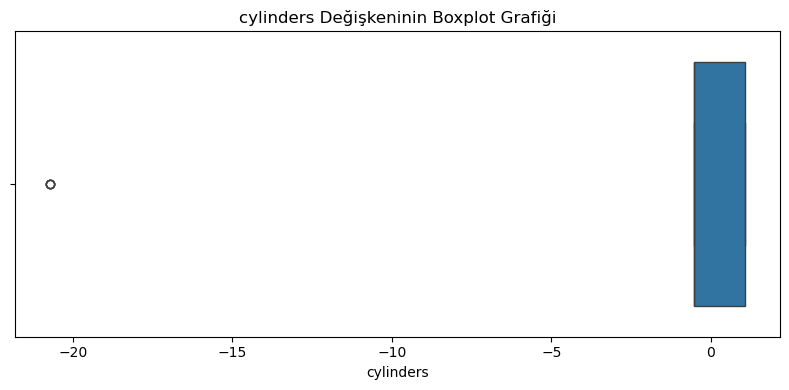

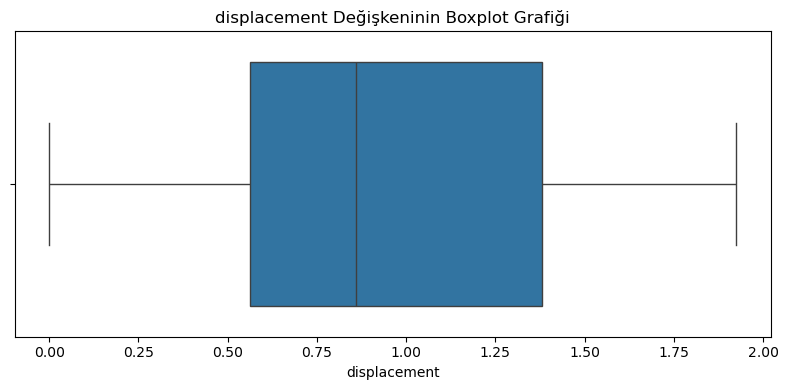

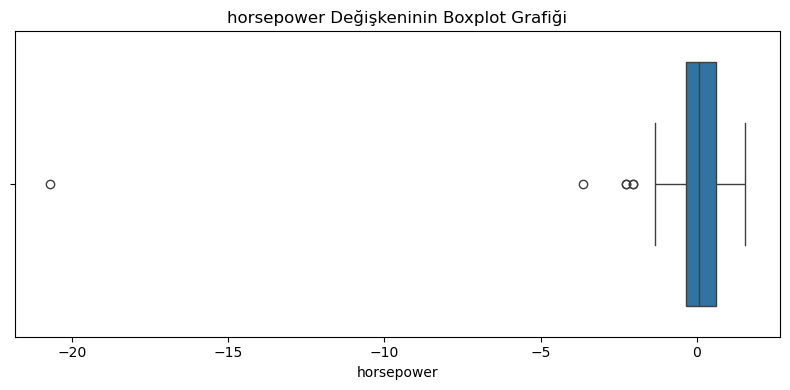

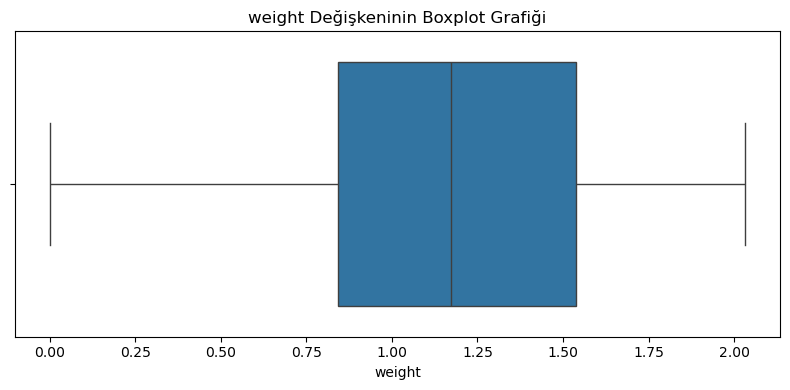

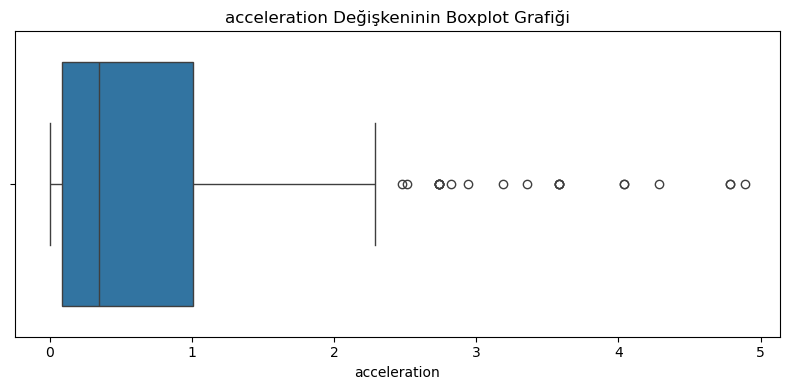

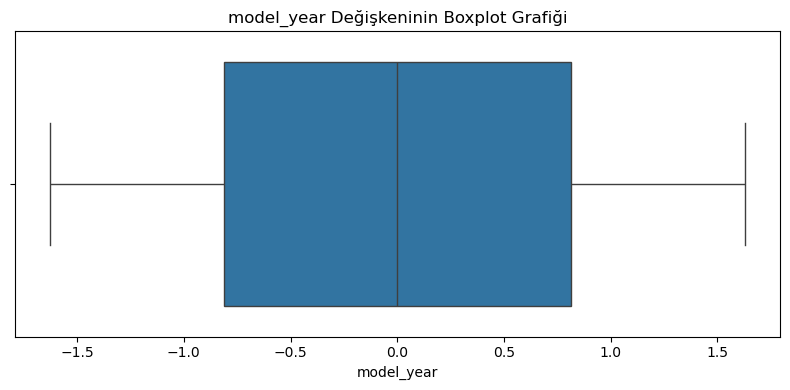

In [53]:
plot_distributions(X_train_transformed, plot_type='box')

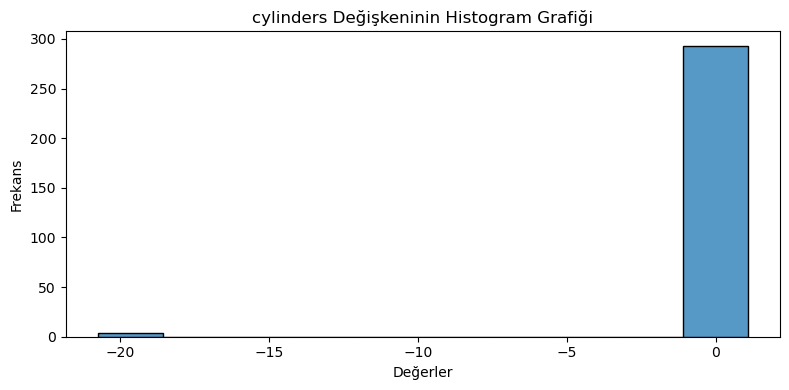

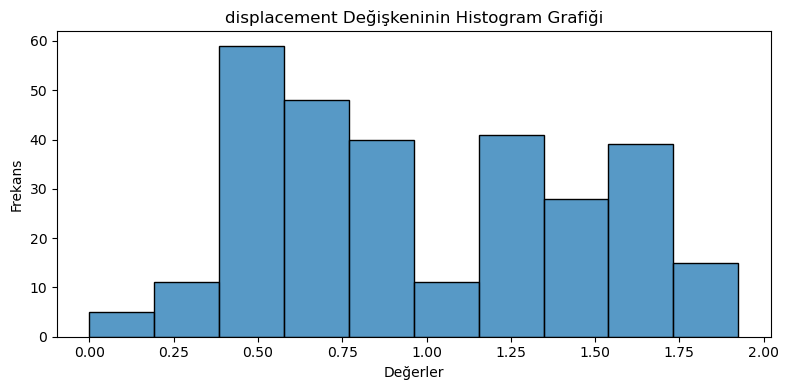

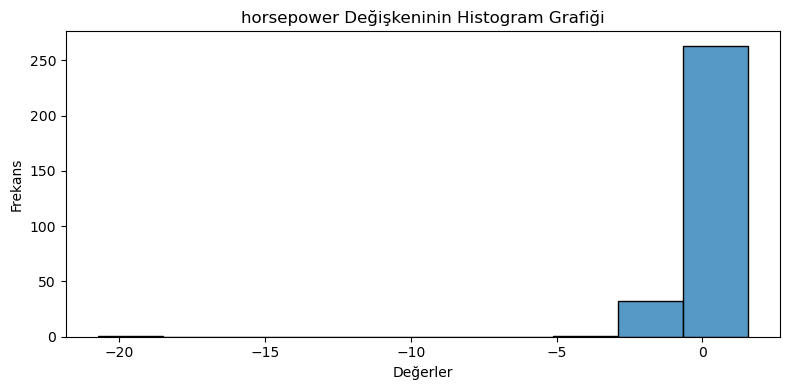

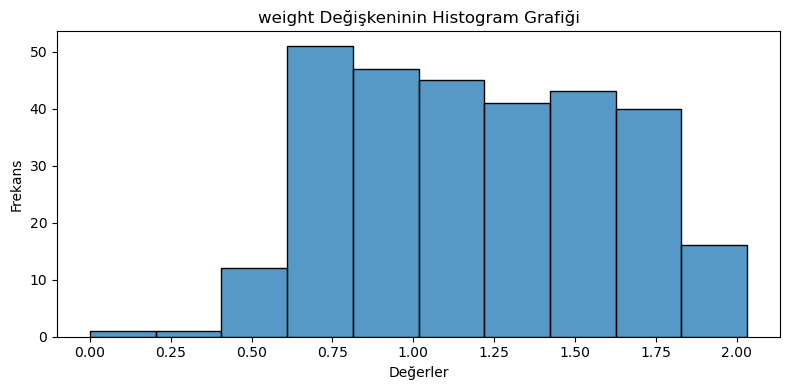

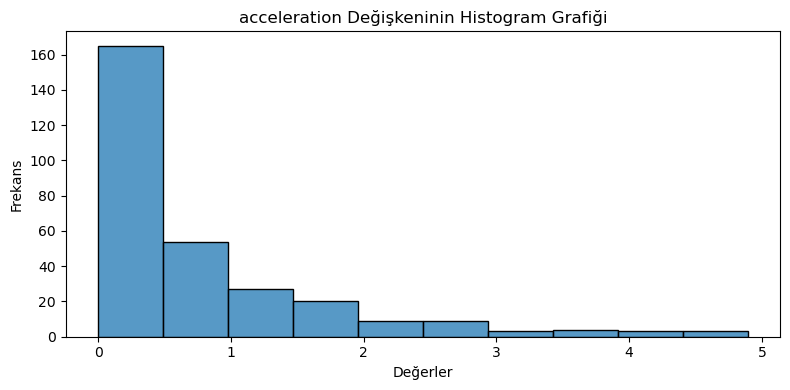

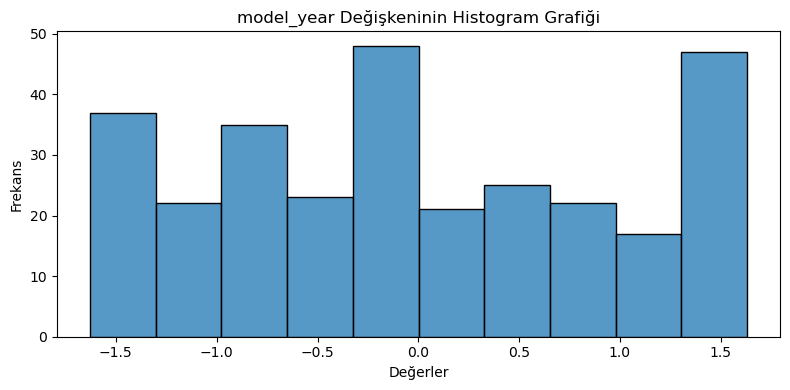

In [54]:
plot_distributions(X_train_transformed, plot_type='hist')

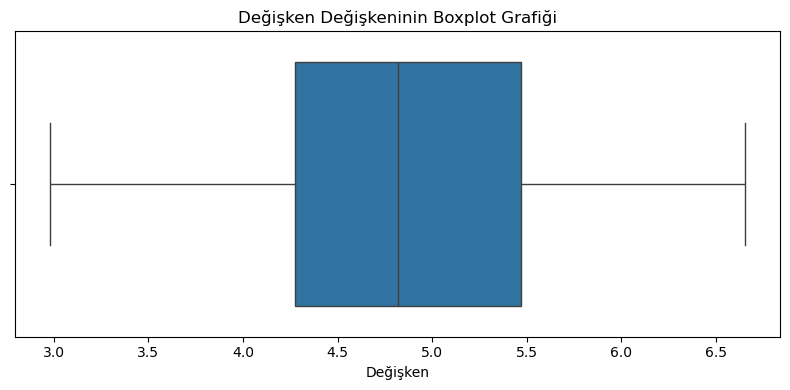

In [55]:
plot_distributions(y_train_transformed, plot_type='box')

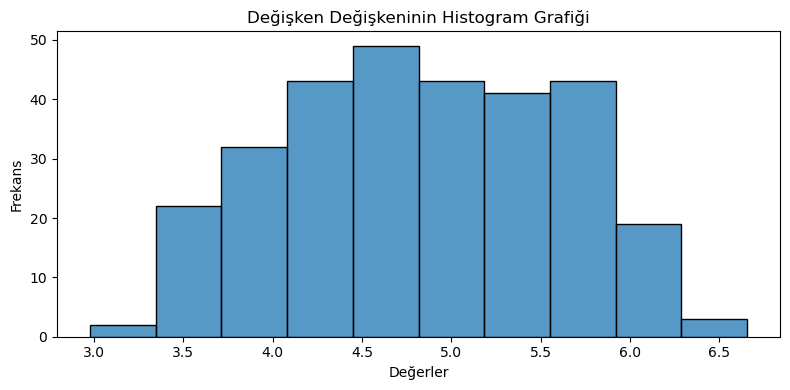

In [56]:
plot_distributions(y_train_transformed, plot_type='hist')

In [57]:
model_transformed = ElasticNet(
    alpha = best_alpha,
    l1_ratio = best_l1_ratio,
    max_iter=50000,
    tol=1e-4,
    fit_intercept=True
)

model_transformed.fit(X_train_transformed, y_train_transformed)

ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=50000)

In [58]:
y_pred_transformed = model_transformed.predict(X_train_transformed)
resid_transformed = y_train_transformed - y_pred_transformed

In [59]:
y_transform_type = best_y_transform
params_y = transformation_params['y']
lam_y = params_y['lambda']
shift_y = params_y['shift']

In [60]:
train_dw_transformed = durbin_watson(resid_transformed)
train_dw_transformed

np.float64(1.9948651946712732)

In [61]:
def inverse_transform_predictions(predictions, transform_type, transform_params):
    shifted_predictions = None
    original_scale_predictions = None
    shift = transform_params.get('shift', 0)
    lam = transform_params.get('lambda')
    
    if transform_type == 'Log':
        shifted_predictions = np.exp(predictions)
    elif transform_type == 'Sqrt':
        shifted_predictions = np.square(predictions)
    elif transform_type == 'Box-Cox':
        if lam is None:
            raise ValueError("Box-Cox ters dönüşümü için lambda değeri gerekli.")
        shifted_predictions = inv_boxcox(predictions, lam)
    elif transform_type == 'Reciprocal':
        original_scale_predictions = 1.0 / predictions
    elif transform_type == 'Square':
        predictions[predictions < 0] = 0
        shifted_predictions = np.sqrt(predictions)
    elif transform_type == 'Original':
        original_scale_predictions = predictions
    else:
        raise ValueError(f"Bilinmeyen y dönüşüm tipi '{transform_type}'")

    if shifted_predictions is not None:
        original_scale_predictions = shifted_predictions - shift
        
    if original_scale_predictions is None:
        raise ValueError("Ters dönüşüm sonrası tahminler hesaplanamadı!")
        
    return original_scale_predictions

y_pred_original = inverse_transform_predictions(y_pred_transformed, best_y_transform, transformation_params['y'])


In [62]:
y_pred_transformed_original_scale = inverse_transform_predictions(
    predictions=y_pred_transformed,
    transform_type=best_y_transform,
    transform_params=transformation_params['y']
)
print("Tahminler orijinal ölçeğe başarıyla geri çevrildi.")

Tahminler orijinal ölçeğe başarıyla geri çevrildi.


In [63]:
train_r2_final = r2_score(y_train_no_outliers, y_pred_transformed_original_scale)
print(train_r2_final)

0.8969389076105716


In [64]:
train_mae_final = mean_absolute_error(y_train_no_outliers, y_pred_transformed_original_scale)
print(train_mae_final)

1.8179194648034787


In [65]:
perform_and_print_assumption_tests(resid_transformed, X_train_transformed)


Shapiro-Wilk Testi: W İstatistiği = 0.99, p değeri = 0.05304
İstatistiksel olarak, artıkların normal dağıldığı anlamlı bir şekilde söylenebilir.

Breusch-Pagan Testi: p değeri = 0.06665
İstatistiksel olarak, artıkların sabit varyansa sahip olduğu anlamlı bir şekilde söylenebilir.


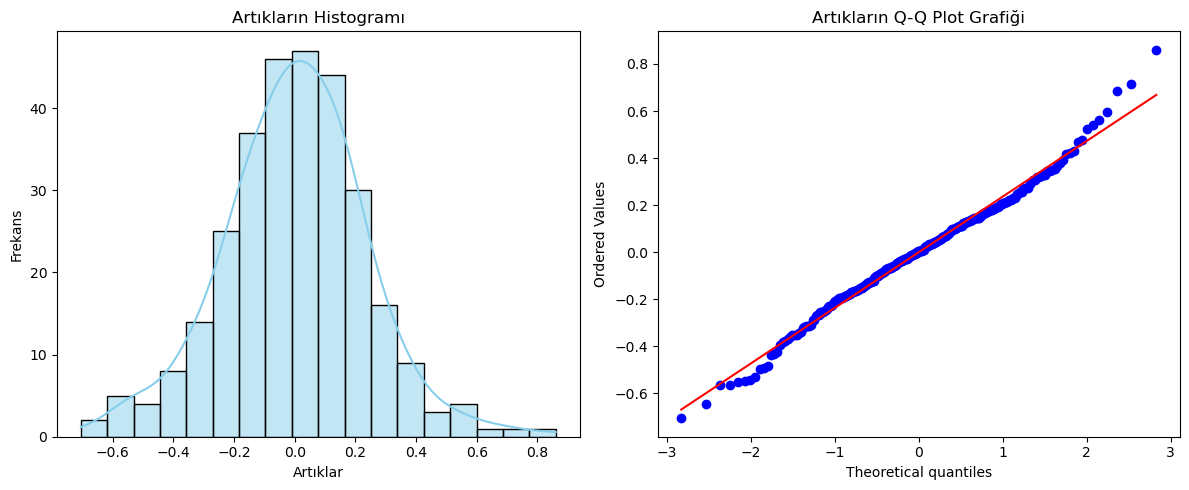

In [66]:
plot_residuals(resid_transformed)

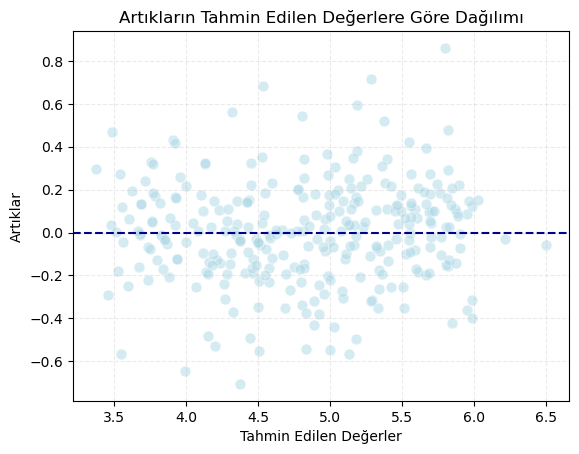

In [67]:
plot_residuals_vs_fitted(y_pred_transformed, resid_transformed)

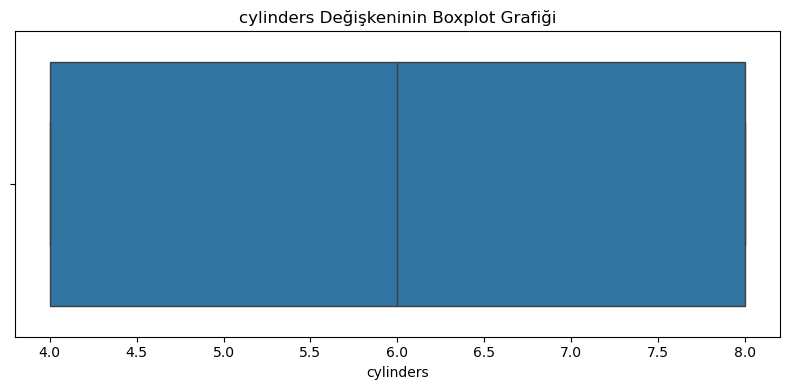

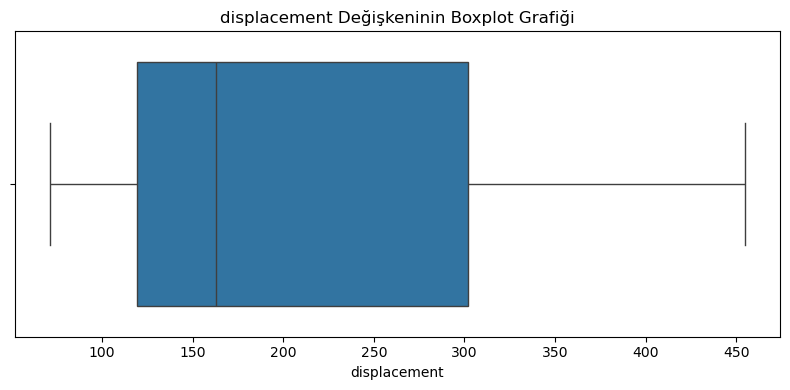

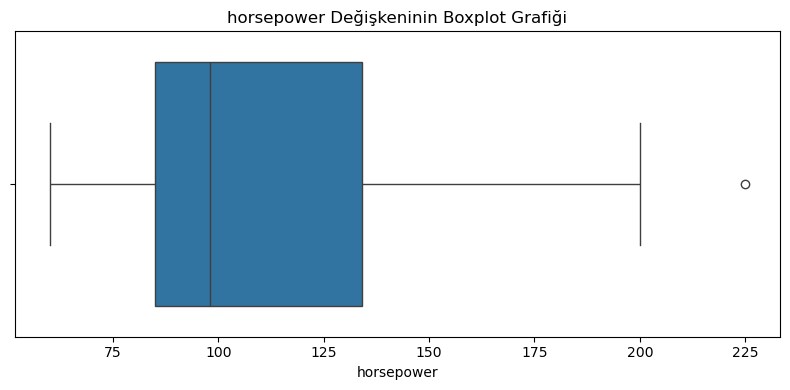

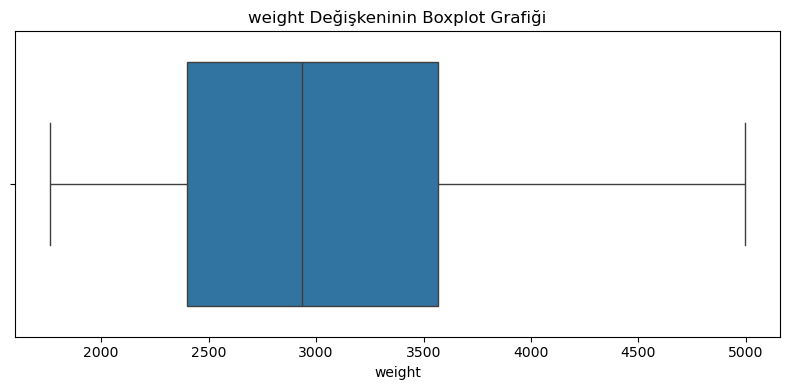

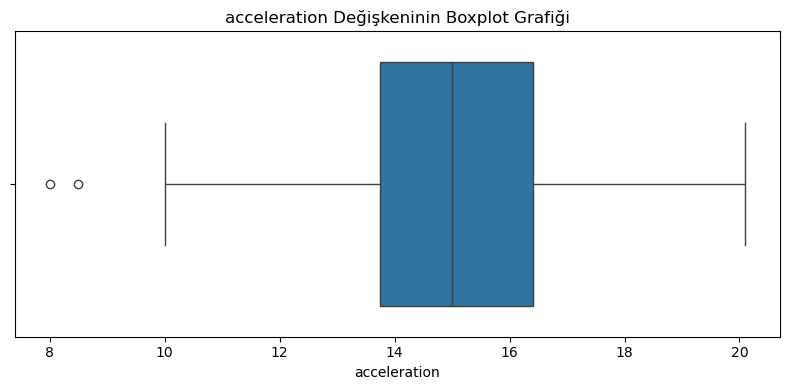

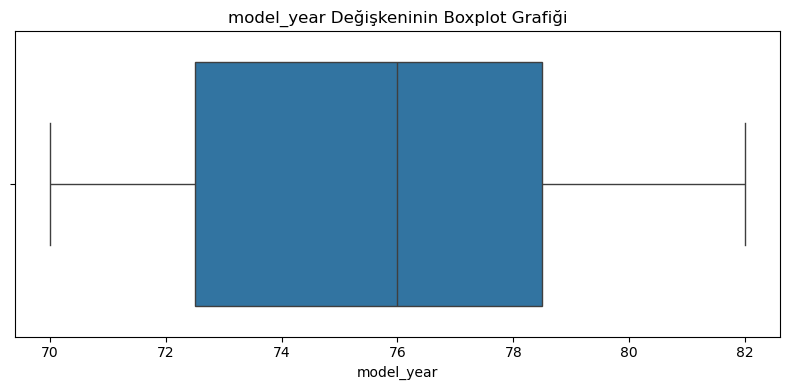

In [68]:
plot_distributions(X_test, plot_type='box')

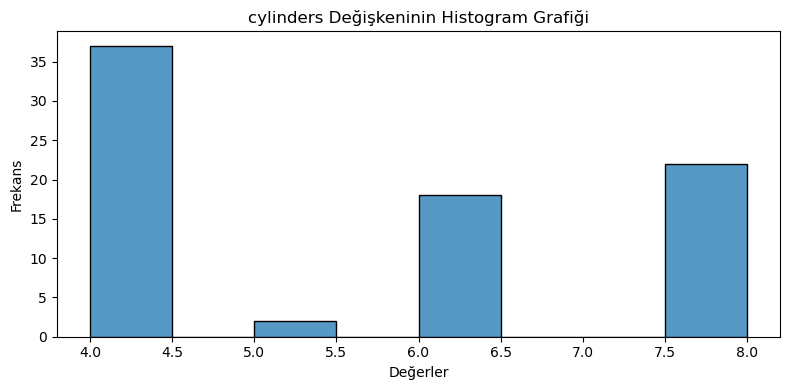

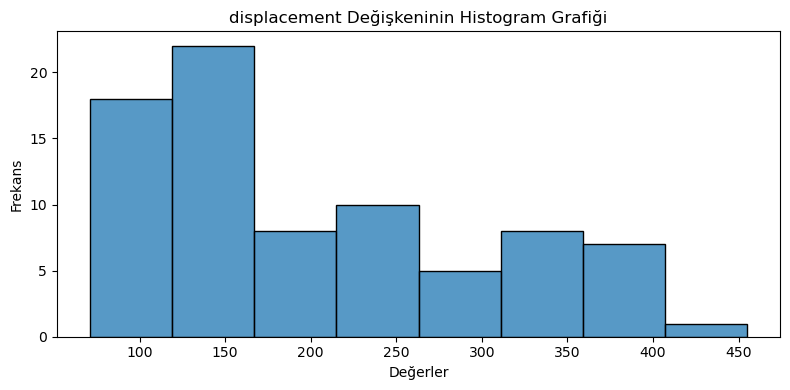

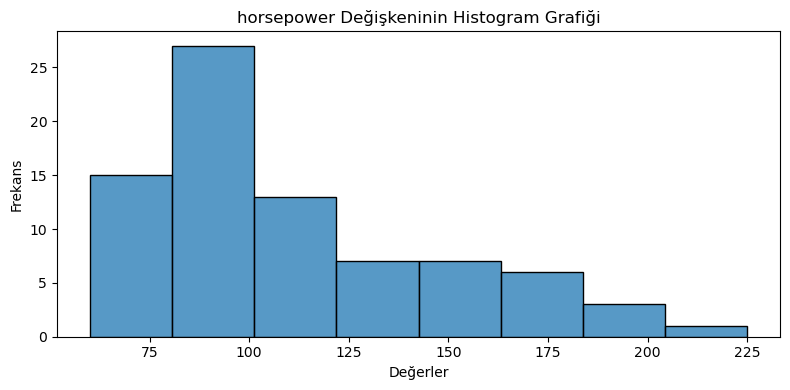

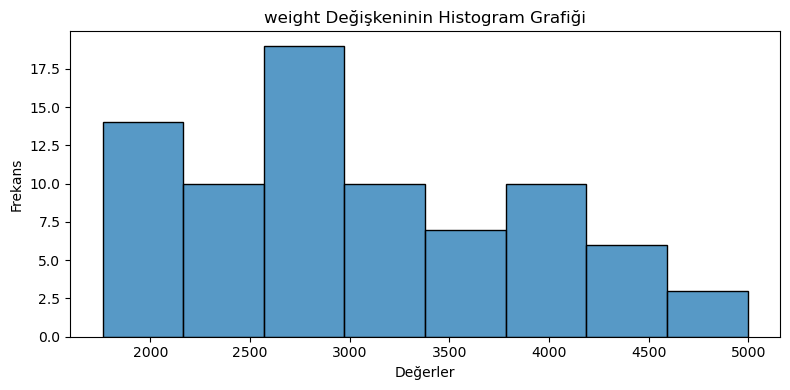

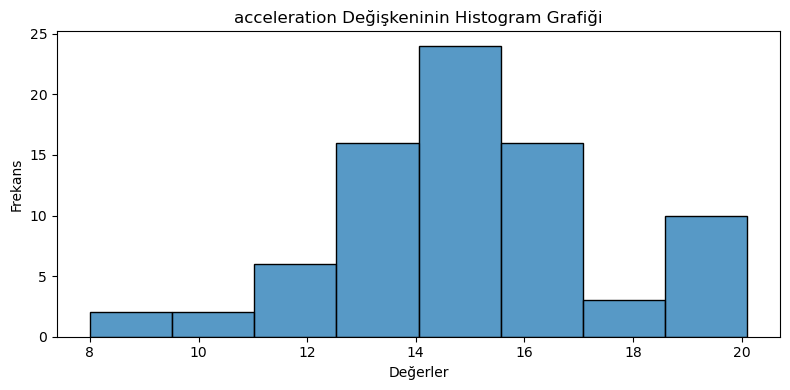

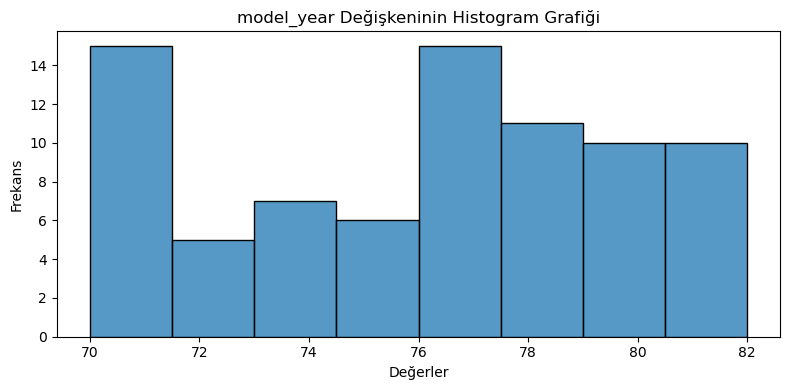

In [69]:
plot_distributions(X_test, plot_type='hist')

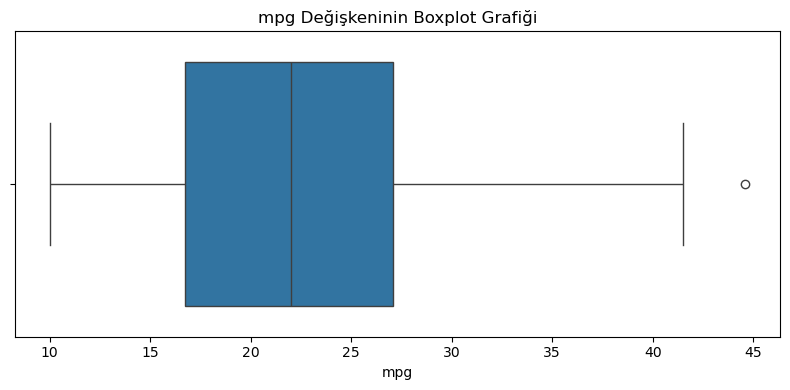

In [70]:
plot_distributions(y_test, plot_type='box')

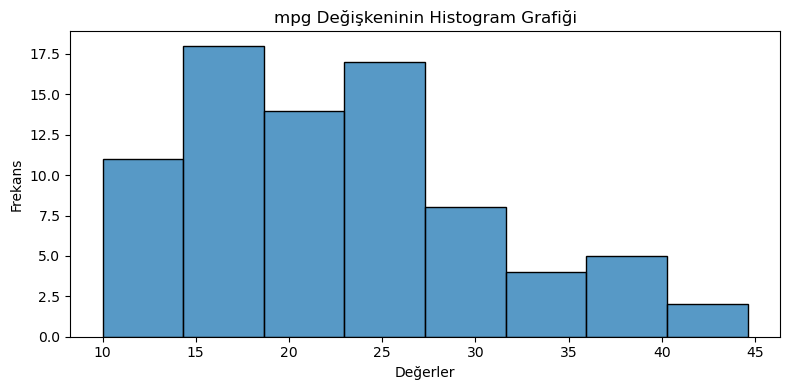

In [71]:
plot_distributions(y_test, plot_type='hist')

In [72]:
print("En İyi Dönüşüm Kombinasyonu:")

print("-" * 40)

print(f"'{y_name}' Sütunu Dönüşümü: {best_y_transform}")
for feature, transform in zip(feature_names, best_x_transforms):
    print(f"'{feature}' Sütunu Dönüşümü: {transform}")

print("-" * 80)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Bağımsız değişkenler standardize edildi.")

y_test_shifted = y_test + transformation_params['y']['shift']
y_test_transformed = apply_transformation_safe(y_test_shifted, best_y_transform)

X_test_transformed = pd.DataFrame(index=X_test_scaled.index)

print("-" * 80)

for i, col_name in enumerate(feature_names):
    transform_type = best_x_transforms[i]
    params = transformation_params[col_name] 
    
    data_to_transform = X_test_scaled[col_name].values + params['shift']
    
    if transform_type == "Box-Cox":
        lam = params['lambda']
        transformed_data = stats.boxcox(data_to_transform, lmbda=lam)
        X_test_transformed[col_name] = transformed_data
        print(f"-> '{col_name}' için Box-Cox uygulandı (Kullanılan shift={params['shift']:.4f}, lambda={lam:.4f})")
    else:
        X_test_transformed[col_name] = apply_transformation_safe(pd.Series(data_to_transform), transform_type)
        print(f"-> '{col_name}' için '{transform_type}' uygulandı (Kullanılan shift={params['shift']:.4f})")

print("\nTest verisinin dönüşümü başarıyla tamamlandı.")

En İyi Dönüşüm Kombinasyonu:
----------------------------------------
'mpg' Sütunu Dönüşümü: Box-Cox
'cylinders' Sütunu Dönüşümü: Log
'displacement' Sütunu Dönüşümü: Sqrt
'horsepower' Sütunu Dönüşümü: Log
'weight' Sütunu Dönüşümü: Sqrt
'acceleration' Sütunu Dönüşümü: Square
'model_year' Sütunu Dönüşümü: Original
--------------------------------------------------------------------------------
Bağımsız değişkenler standardize edildi.
--------------------------------------------------------------------------------
-> 'cylinders' için 'Log' uygulandı (Kullanılan shift=1.4306)
-> 'displacement' için 'Sqrt' uygulandı (Kullanılan shift=1.1920)
-> 'horsepower' için 'Log' uygulandı (Kullanılan shift=1.4249)
-> 'weight' için 'Sqrt' uygulandı (Kullanılan shift=1.5804)
-> 'acceleration' için 'Square' uygulandı (Kullanılan shift=0.0000)
-> 'model_year' için 'Original' uygulandı (Kullanılan shift=0.0000)

Test verisinin dönüşümü başarıyla tamamlandı.


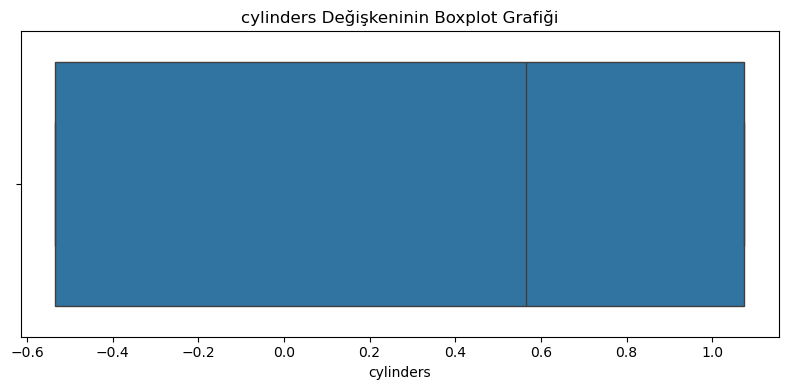

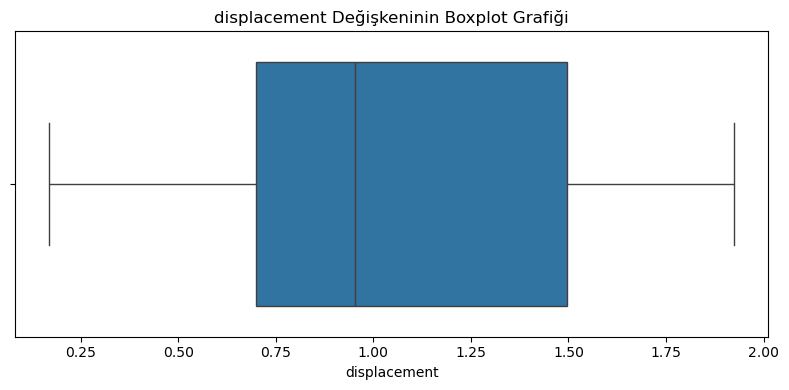

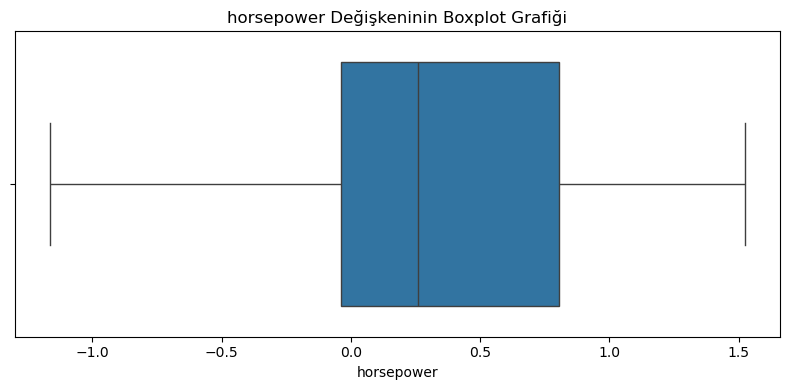

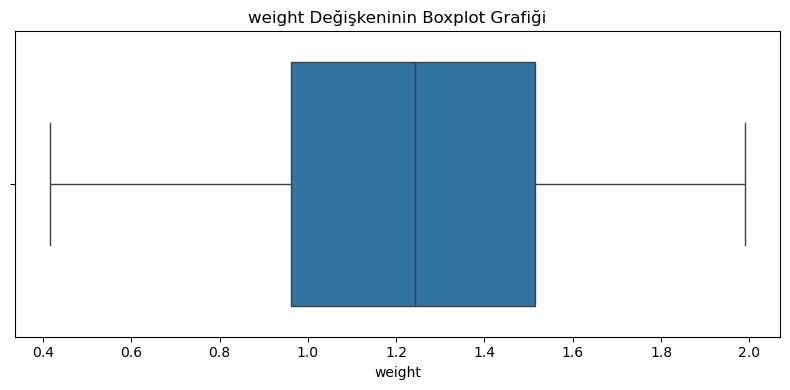

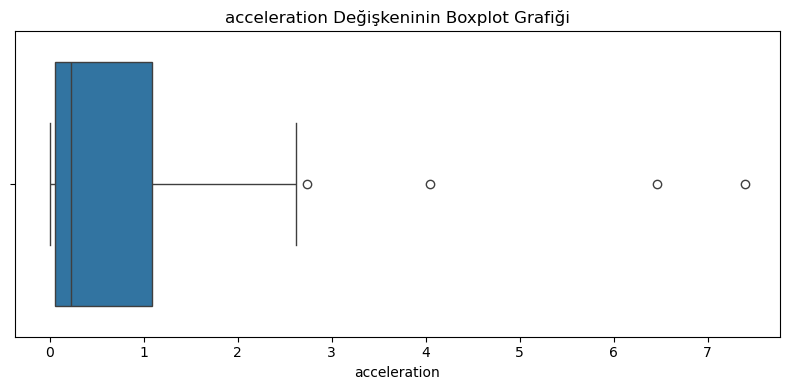

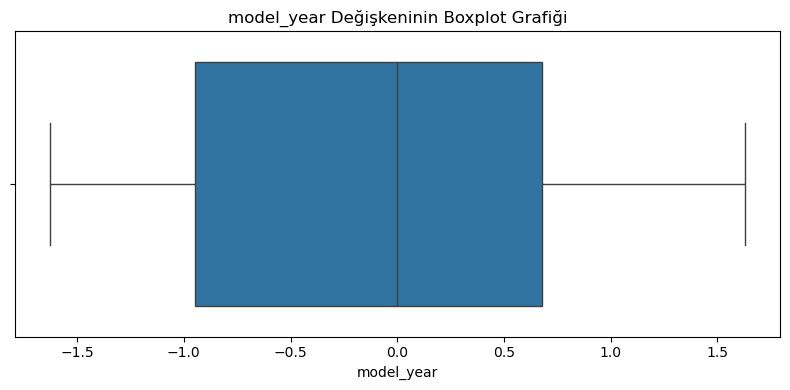

In [73]:
plot_distributions(X_test_transformed, plot_type='box')

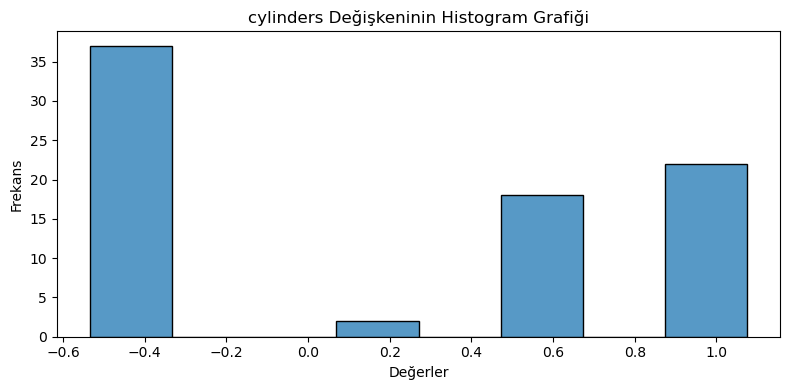

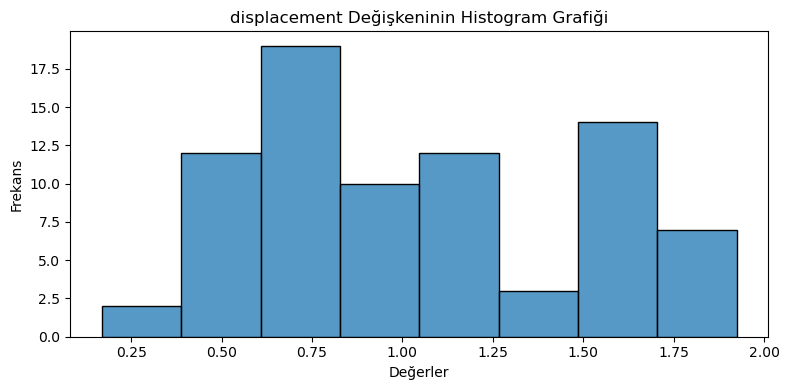

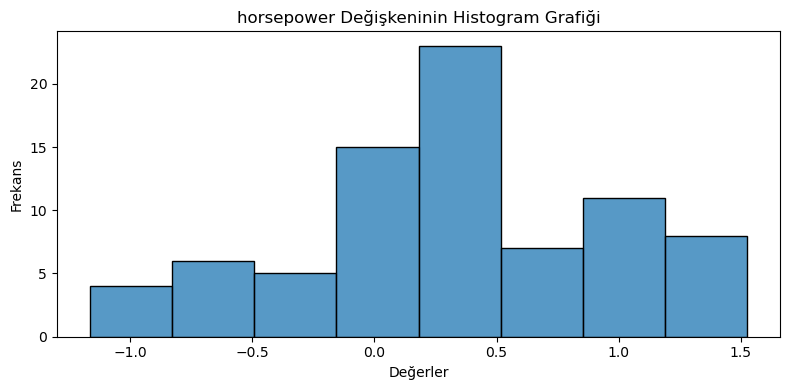

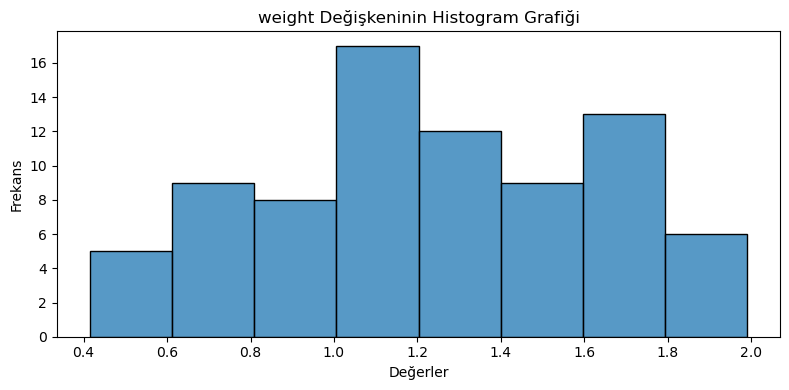

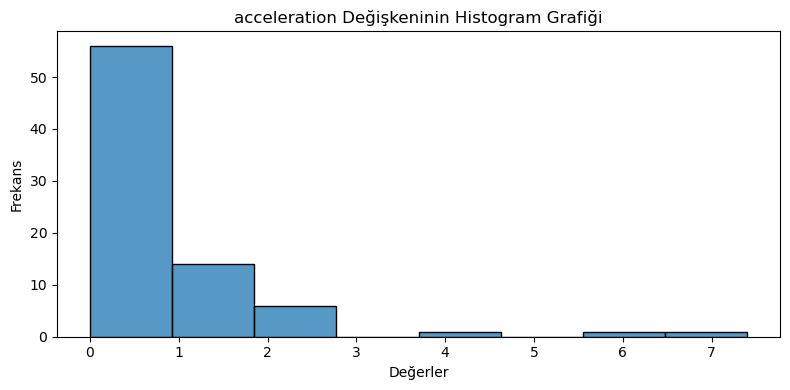

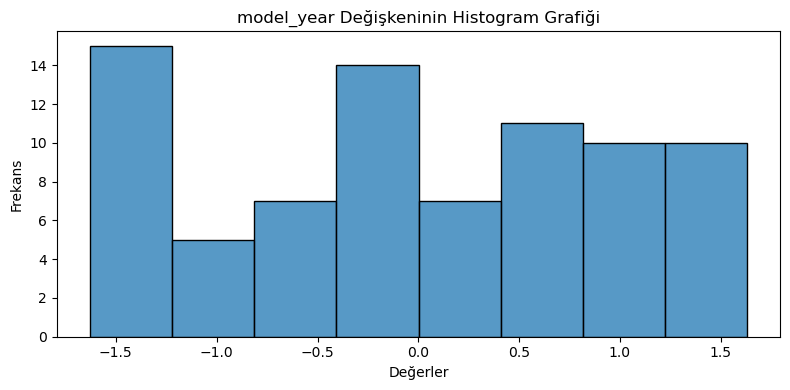

In [74]:
plot_distributions(X_test_transformed, plot_type='hist')

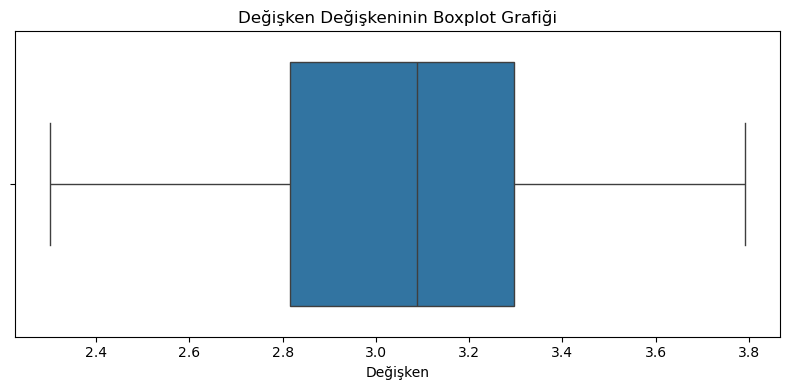

In [75]:
plot_distributions(y_test_transformed, plot_type='box')

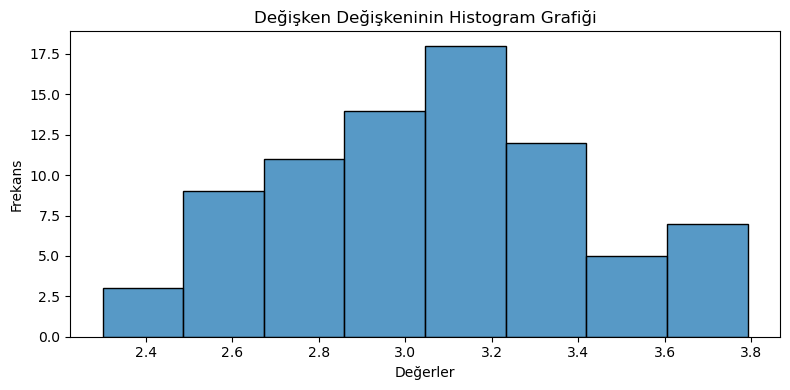

In [76]:
plot_distributions(y_test_transformed, plot_type='hist')

In [77]:
y_test_pred_transformed = model_transformed.predict(X_test_transformed)

In [78]:
resid_test = y_test_transformed - y_test_pred_transformed

In [79]:
test_dw = durbin_watson(resid_test)
test_dw

np.float64(0.09806164429843699)

In [80]:
y_pred_test_original_scale = inverse_transform_predictions(
    predictions=y_test_pred_transformed,
    transform_type=best_y_transform,
    transform_params=transformation_params['y']
)

print("Tahminler orijinal ölçeğe başarıyla geri çevrildi.")

Tahminler orijinal ölçeğe başarıyla geri çevrildi.


In [81]:
test_r2 = r2_score(y_test, y_pred_test_original_scale) 
print(test_r2)

0.8113953657275399


In [82]:
test_mae = mean_absolute_error(y_test, y_pred_test_original_scale) 
print(test_mae)

2.3385568704386452


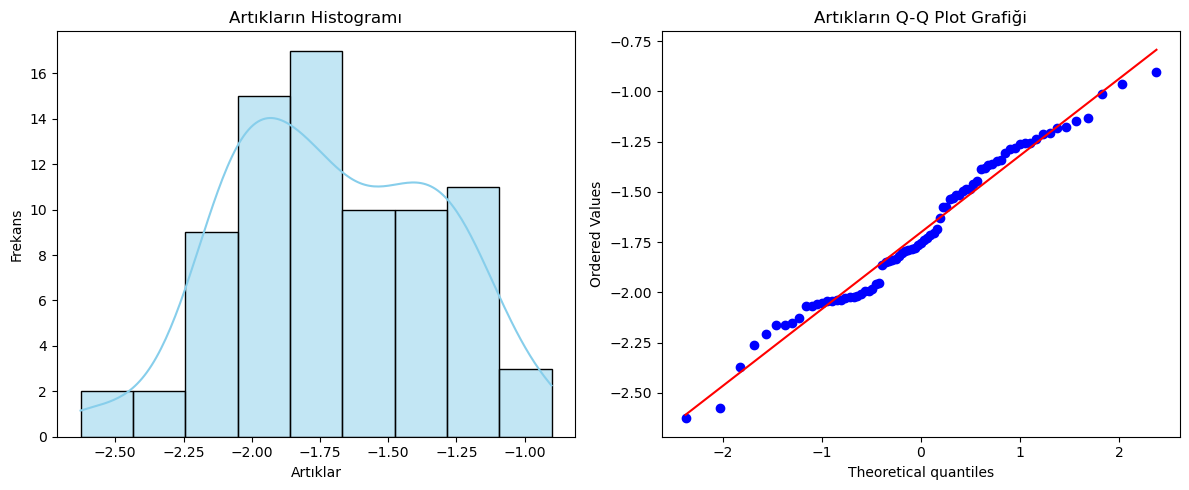

In [83]:
plot_residuals(resid_test)

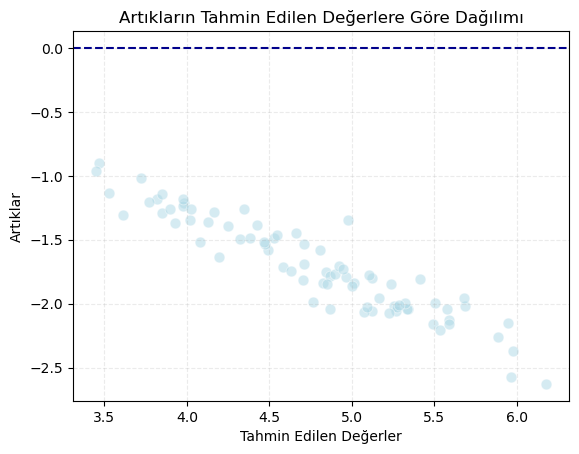

In [84]:
plot_residuals_vs_fitted(y_test_pred_transformed, resid_test)

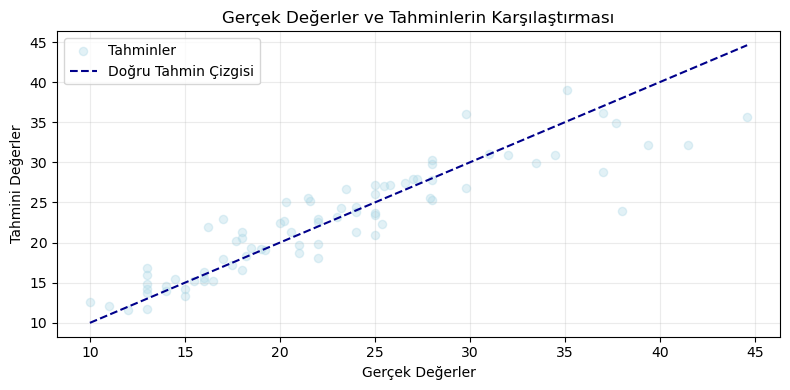

In [85]:
plt.figure(figsize=(8, 4))

plt.scatter(y_test, y_pred_test_original_scale, s=35, alpha=0.35, color='lightblue', label='Tahminler')

min_val = min(y_test.min(), y_pred_test_original_scale.min())
max_val = max(y_test.max(), y_pred_test_original_scale.max())

plt.plot([min_val, max_val], [min_val, max_val], '--', color='darkblue', label='Doğru Tahmin Çizgisi')

plt.title('Gerçek Değerler ve Tahminlerin Karşılaştırması')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmini Değerler')
plt.legend()
plt.grid(True, alpha = 0.25)
plt.tight_layout()
plt.show()